# Point Cloud Track Reconstruction for LArIAT

Converting 2D ADC wire chamber data to sparse point clouds for particle track reconstruction.

## Approach
1. Find local maxima in ADC data (particle hits)
2. Build graph connecting nearby points
3. Use direction analysis to distinguish overlapping particles
4. Reconstruct particle tracks from connected components

## Goal
Improve track reconstruction for overlapping particles in proton-deuteron events.

In [599]:
import sys
sys.path.append('..')

In [600]:
from lariat import Event

In [ ]:
import cv2
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from skimage.morphology import binary_closing, remove_small_objects, square, binary_dilation, medial_axis, thin, skeletonize
from sklearn.linear_model import RANSACRegressor

from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import pdist
from scipy.spatial import cKDTree

from collections import Counter

In [623]:
deuterons = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/deuteron_candidates_bbox_t100.csv') # from within vertices bounding box
protons = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/protons_one_track_filepaths.csv') # with only one track from reco

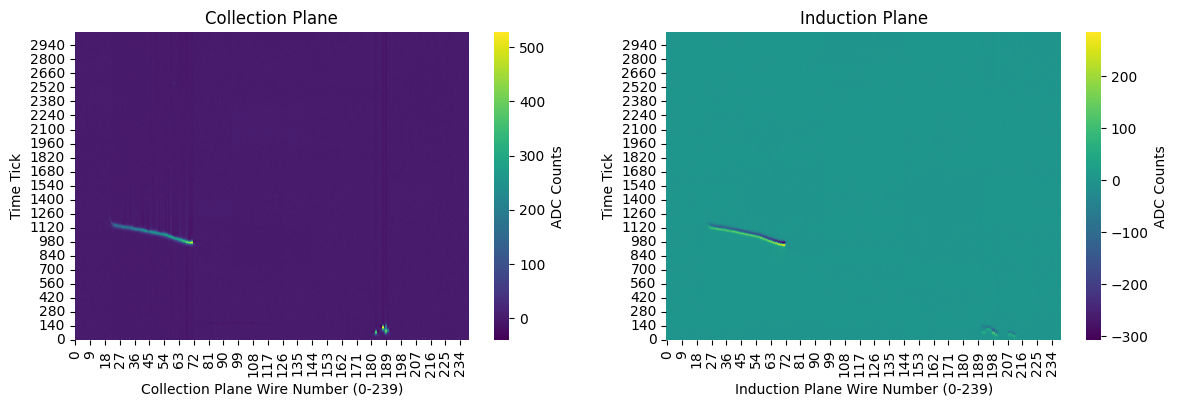

In [820]:
n = 2324           # 100 good noisy event, 
                # 4 particle splitting into 2 tracks
                # 6 clean deuteron
event = Event(deuterons.iloc[n]['file_path'], index=deuterons.iloc[n]['event_index'])
induction = event.induction
collection = event.collection

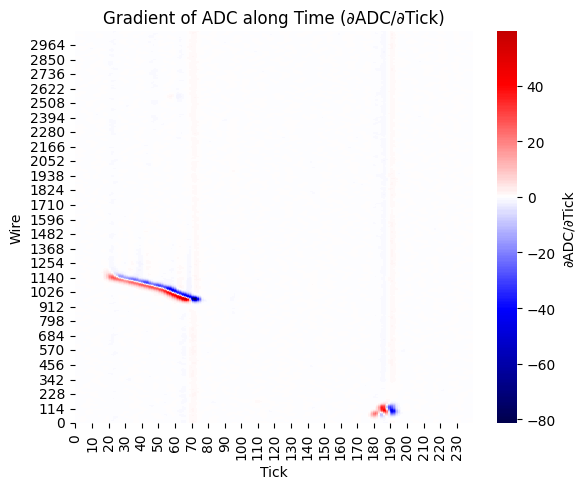

In [821]:
adc_smooth = gaussian_filter(collection, sigma=(2, 2))  # blur only along time (y)

grad_y = np.gradient(adc_smooth, axis=0)

plt.figure(figsize=(6, 5))
sns.heatmap(grad_y.T, cmap='seismic', center=0, cbar_kws={'label': '∂ADC/∂Tick'})

plt.title("Gradient of ADC along Time (∂ADC/∂Tick)")
plt.xlabel("Tick")
plt.ylabel("Wire")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Using grad, choosing where sign change happens (grad = 0)

In [822]:
plane = collection
plane = plane.copy()
plane[plane <= 50] = 0

adc_smooth = gaussian_filter(plane, sigma=(2, 2))  # (time, wire)

grad_y = np.gradient(plane, axis=0)

# Detect zero-crossings: from + to - means a local maximum
sign_change = np.diff(np.sign(grad_y), axis=0)  # shape becomes (n-1, m)
maxima_mask = sign_change < 0  # where gradient went from + to -

# Shift mask to align with original data shape
maxima_mask = np.pad(maxima_mask, ((1, 0), (0, 0)), mode='constant')

# ADC threshold
adc_threshold = np.percentile(plane, 98) * 0.5
above_threshold = plane > adc_threshold
peak_mask = maxima_mask & above_threshold


In [823]:
# finding local maxima per wire, 300 time tick window sweep

time_block_size = 300  # number of ticks per time chunk
num_wires, num_ticks = peak_mask.shape
refined_peak_mask = np.zeros_like(peak_mask, dtype=bool)

for wire in range(num_wires):
    for t_start in range(0, num_ticks, time_block_size):
        t_end = min(t_start + time_block_size, num_ticks)
        block = peak_mask[wire, t_start:t_end]
        
        if not np.any(block):
            continue
        
        tick_indices = np.where(block)[0]
        adc_block = adc_smooth[wire, t_start:t_end]
        best_idx = tick_indices[np.argmax(adc_block[tick_indices])]
        
        refined_peak_mask[wire, t_start + best_idx] = True

peak_mask = refined_peak_mask

/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_4092/4098402621.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.legend(); plt.tight_layout(); plt.show()


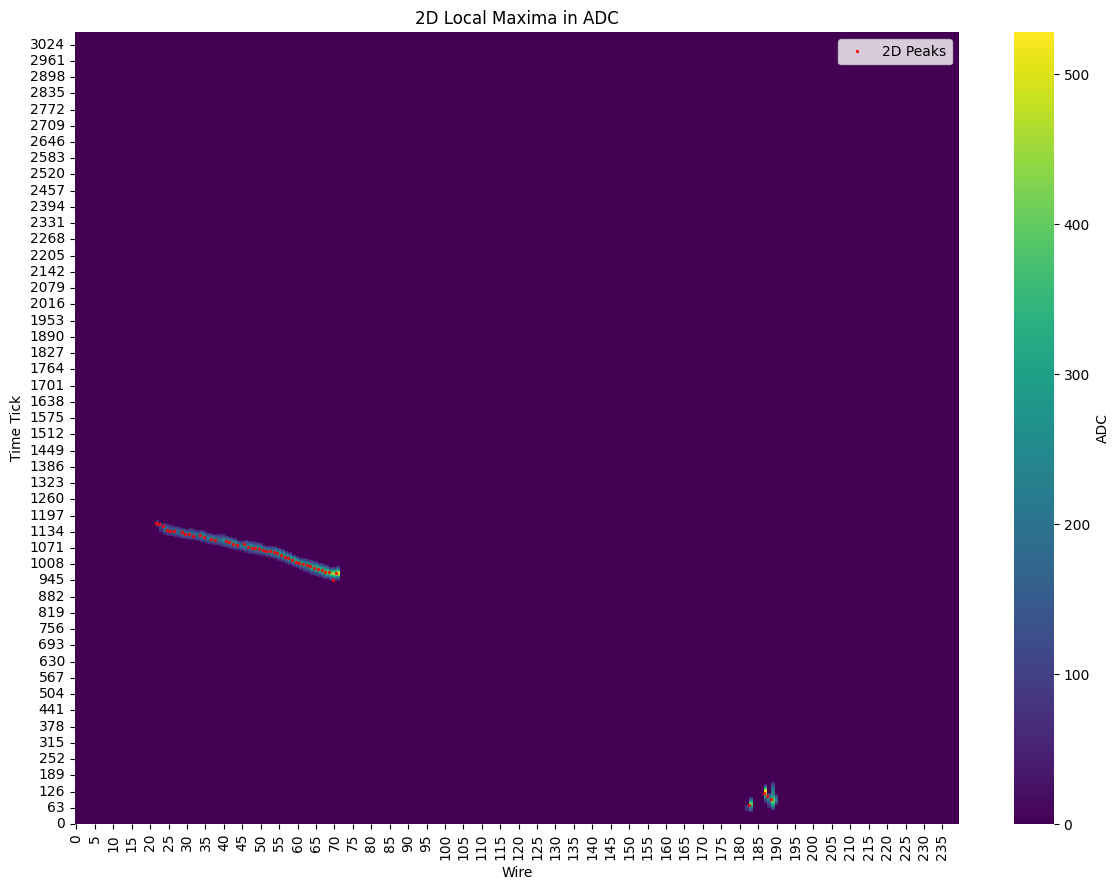

In [824]:
ys, xs = np.where(peak_mask)  # (wire, tick)

plt.figure(figsize=(12, 9))
sns.heatmap(plane.T, cmap='viridis', cbar_kws={'label': 'ADC'})
plt.plot(ys, xs, 'r.', markersize=3, alpha=0.8, label='2D Peaks')
plt.ylabel("Time Tick")
plt.xlabel("Wire")
plt.gca().invert_yaxis()
plt.title("2D Local Maxima in ADC")
plt.legend(); plt.tight_layout(); plt.show()


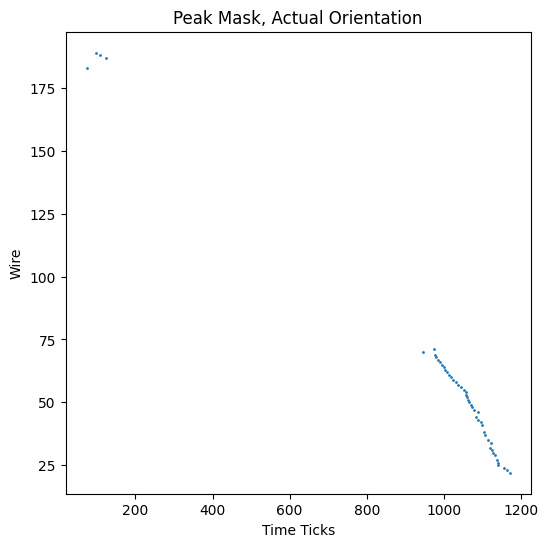

In [825]:
plt.figure(figsize=(6,6))
plt.scatter(xs, ys, s=4, lw=0)
plt.title('Peak Mask, Actual Orientation')
plt.xlabel('Time Ticks')
plt.ylabel('Wire')
plt.show()

# TODO: Heirarchy

In [826]:
# data to make graph

ys, xs = np.nonzero(peak_mask)
adc = plane[ys, xs]

maxima = np.column_stack((ys, xs, adc))

points = maxima[:, :2]
adc = maxima[:, 2]

Most common distance: 5.1 (occurs 6 times)


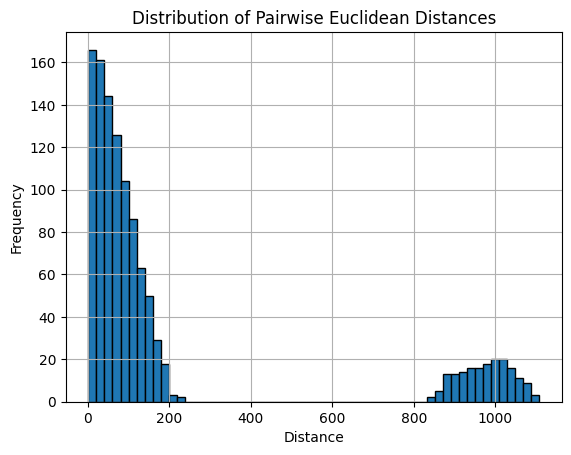

In [827]:
dists = pdist(points); rounded_dists = np.round(dists, decimals=2)
counter = Counter(rounded_dists)
most_common_dist, count = counter.most_common(1)[0]

print(f"Most common distance: {most_common_dist} (occurs {count} times)")
plt.hist(rounded_dists, bins='auto', edgecolor='black')
plt.title("Distribution of Pairwise Euclidean Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Directed Graph

In [828]:
tree = cKDTree(points)                             # make a trea from the points
 
k = 10
rows = np.repeat(np.arange(len(points)), k)
cols   = tree.query(points, k+1)[1][:, 1:].ravel() # find nearest neighbours
pairs  = np.column_stack((rows, cols))

In [829]:
G = nx.DiGraph()

for idx, (ys, xs) in enumerate(points):
    G.add_node(idx, y=ys, x=xs, adc=adc[idx], pos=(xs, ys))

for i, j in zip(rows, cols):
    y1, x1 = points[i]
    y2, x2 = points[j]

    dx, dy = x2 - x1, y2 - y1
    angle = np.degrees(np.arctan2(dy, dx))
    adiff = abs(adc[i] - adc[j])
    distance = np.hypot(dy, dx)

    # if distance > 40:
    #     continue
    
    # choosing direction based on angle
    if np.isclose(dy, 0.0):            # ≈ horizontal → fall back to x
        u, v = (i, j) if dx > 0 else (j, i)
    else:                              # vertical / diagonal
        u, v = (i, j) if dy > 0 else (j, i)   # arrow toward +y

    dx2 = points[v][1] - points[u][1]
    dy2 = points[v][0] - points[u][0]
    angle = np.degrees(np.arctan2(dy2, dx2))

    if not G.has_edge(u, v):
        G.add_edge(u, v, 
                adc = adiff,
                distance = distance,
                angle = angle)

In [830]:
print(f"{G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

48 nodes, 281 edges


Making tracks

In [831]:
# CHOOSE BASED ON ANGLE, DIFFERENCE IN ADC, MOMENTUM ON DIRECTION, DISTANCE
# NODES WITH ONLY OUTGOING AT VERTICES, NODES WITH ALL INCOMING (+ CUT ON EXTREME ANGLE CHANGE EDGES) ARE END POINTS

# TODO: PROBLEMS WITH FINDING ALL VERTICES PROPERLY (if they have in going edges)
# TODO: Nodes latching onto nodes from other tracks. 
# TODO: Implement lookahead for initial node to choose best edges. Too much noise to get a track started. Might be better to pass a window over nodes.
# TODO: Check average angle instead of just previous, fluctuates too much. Might be better to pass a window over nodes.

In [832]:
start_nodes = [n for n in G.nodes if G.in_degree(n) == 0] # nodes with no in going edges
start_nodes

[0]

# Building tracks

Choosing paths from the raw graph

In [833]:
import math

def angle_diff(a1, a2):
    return min(abs(a1-a2) , 360 - abs(a1-a2))

def buildtrack(G, start_node, angle_thresh=120, first_step_max=20, nsigma = 6, adc_thresh=None):
    track = [start_node]
    current = start_node
    prev_angle = None           # TODO: record all angles, to get a sense of global
    prev_adc     = G.nodes[start_node]['adc']
    angles = []
    adcs = []
    dists = []
    
    while True:

        candidates = list(G.successors(current))
        if not candidates:                                                  # if no connections, discard
            break

        best = None
        best_score = float('inf')

        if len(dists) >= 1:
            mu = np.mean(dists)
            sig = np.std(dists, ddof=1)

        else:
            mu = sig = None
        
        
        for nxt in candidates:
            edge = G[current][nxt]
            dist = edge['distance']
            angle = edge['angle']

            if dist > 45:                                                   # if edge longer than 70 discard TODO: hyperparameter tune 
                continue

            if current is start_node and first_step_max is not None:        # first step from starting node should not be too long
                if dist > first_step_max:
                    continue

            if mu is not None and sig > 0:                                  # edge should not be longer than mean + n * std
                if dist > mu + nsigma * sig:
                    continue

            adc_nxt = G.nodes[nxt]['adc']
            if adc_thresh is not None:                                      # adc should not fluctuate more than set threshold TODO: doesn't work well + hyperparameter tune
                if abs(adc_nxt - prev_adc) > adc_thresh:
                    continue

            if prev_angle is not None:                                      # angle should not change more than set threshold TODO: hyperparameter tune
                delta = angle_diff(prev_angle, angle)
                if delta > angle_thresh:
                    continue
            else:
                delta = 0

            if delta < best_score:                                          # choose smallest angle deviation path
                best = nxt
                best_score = delta
                best_dist = dist
                best_adc = adc_nxt

        if best is None:
            break

        track.append(best)
        dists.append(best_dist)
        prev_angle = G[current][best]['angle']; angles.append(prev_angle)
        prev_adc = best_adc
        current = best

    return track, angles

In [834]:
tracks = []
allangles = []
for start in start_nodes:
    track, angles = buildtrack(G, start)
    if len(track) > 5:                                                      # discard tracks shorter than 5 nodes
        tracks.append(track)
        allangles.append(angles)

/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


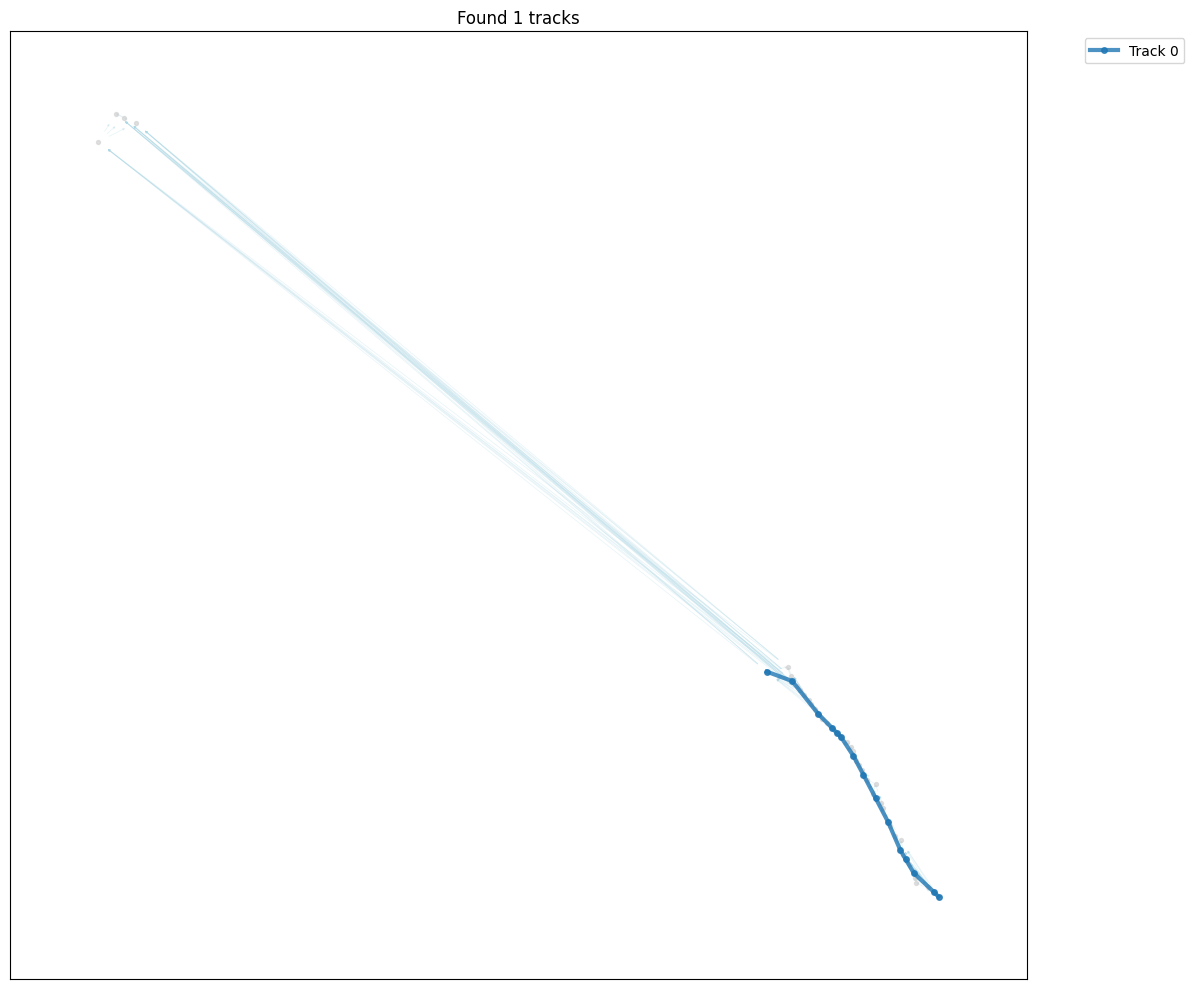

In [835]:
if tracks and len(tracks) > 0:
    pos = nx.get_node_attributes(G, 'pos')
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Draw all edges
    nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=3, 
                          width=0.5, edge_color='lightblue', alpha=0.3)
    
    # Draw all nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=8, 
                          node_color='lightgray', alpha=0.7)
    
    # Draw tracks as colored paths
    colors = plt.cm.tab10(np.linspace(0, 1, len(tracks)))
    
    for i, track in enumerate(tracks):
        track_pos = [pos[node] for node in track]
        track_x = [p[0] for p in track_pos]
        track_y = [p[1] for p in track_pos]
        
        ax.plot(track_x, track_y, 'o-', color=colors[i], 
               linewidth=3, markersize=4, alpha=0.8, label=f'Track {i}')
    
    ax.set_title(f"Found {len(tracks)} tracks")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No tracks to display")

# Stich incomplete tracks together
Based on direction similarity and location correspondence

In [836]:
def circ_mean(a):
    """circular mean of a list of degrees in [0,360)"""
    r = np.deg2rad(a)
    return np.rad2deg(np.arctan2(np.sin(r).mean(), np.cos(r).mean())) % 360

def ang_diff(a,b):
    d = abs(a-b) % 360
    return d if d<=180 else 360-d          # 0 … 180

summary = []                               # list of dicts
for nodes, angs in zip(tracks, allangles):
    if not angs:          # skip single-node tracks
        continue
    summary.append(dict(
        nodes = nodes,
        mean  = circ_mean(angs),           #   ⟨θ⟩
        ys    = points[nodes[0]][0],       #   y  start
        ye    = points[nodes[-1]][0],      #   y  end
    ))

angle_tol = 5        # very very similar angle
stitched  = []
taken     = set()    # indices of tracks absorbed into another

for i, ti in enumerate(summary):
    if i in taken:
        continue

    chain  = list(ti['nodes'])
    for j, tj in enumerate(summary):
        if j==i or j in taken:
            continue
        if ti['ye'] < tj['ys'] and ang_diff(ti['mean'], tj['mean']) <= angle_tol:
            # join i -> j
            chain.extend(tj['nodes'])
            taken.add(j)
            ti['ye'] = tj['ye']            # update tip-y for further joins
    stitched.append(chain)

print(f"stitched {len(tracks) - len(stitched)} trajectories (out of {len(tracks)})")

stitched 0 trajectories (out of 1)


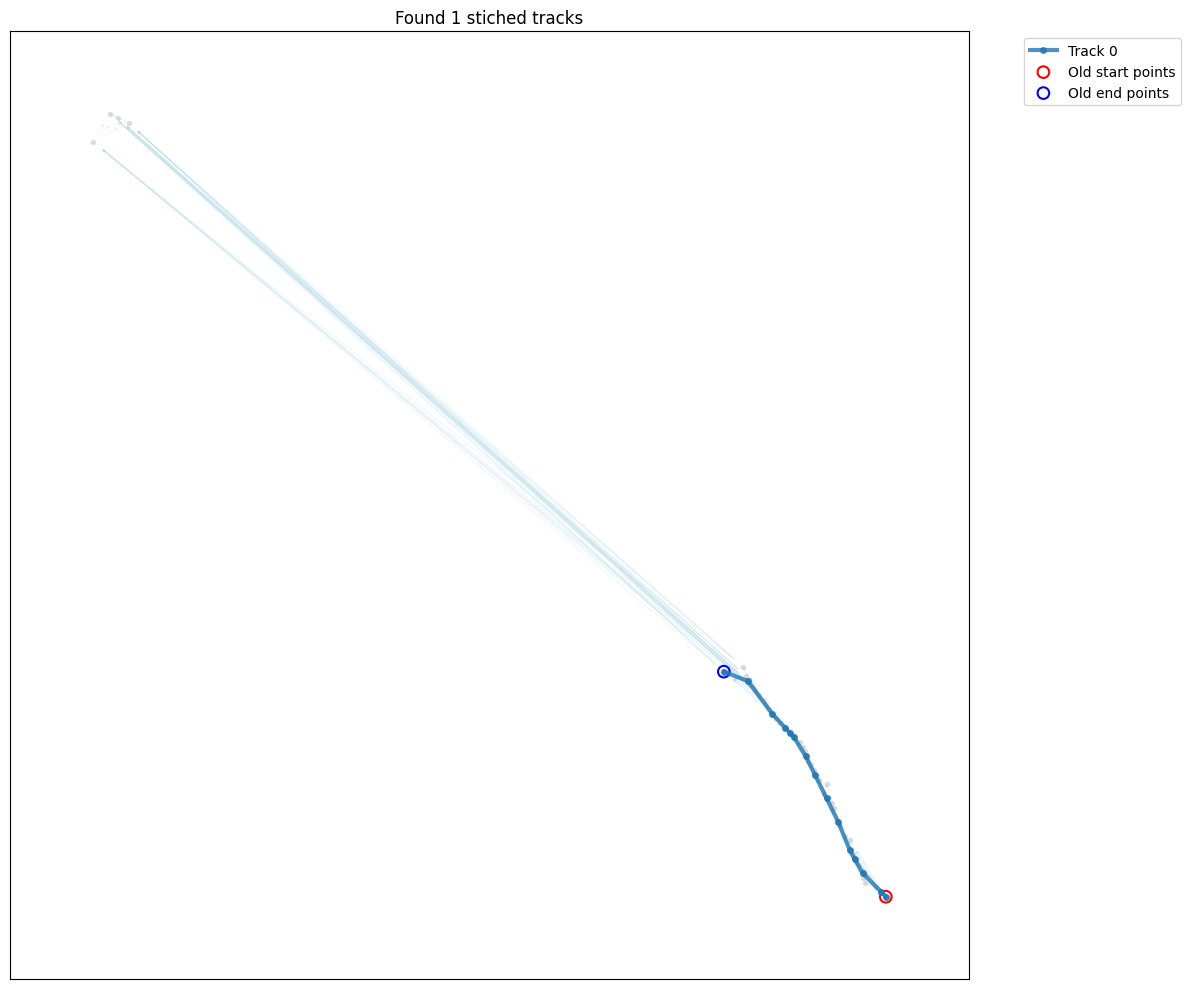

In [837]:
if stitched and len(stitched) > 0:
    pos = nx.get_node_attributes(G, 'pos')
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Draw all edges
    nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=3, 
                          width=0.5, edge_color='lightblue', alpha=0.3)
    
    # Draw all nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=8, 
                          node_color='lightgray', alpha=0.7)
    
    # Draw tracks as colored paths
    colors = plt.cm.tab10(np.linspace(0, 1, len(stitched)))
    
    for i, track in enumerate(stitched):
        track_pos = [pos[node] for node in track]
        track_x = [p[0] for p in track_pos]
        track_y = [p[1] for p in track_pos]
        
        ax.plot(track_x, track_y, 'o-', color=colors[i], 
               linewidth=3, markersize=4, alpha=0.8, label=f'Track {i}')
    
    ax.set_title(f"Found {len(stitched)} stiched tracks")

    xs = [points[trk[0]][1] for trk in tracks]   # x-coords
    ys = [points[trk[0]][0] for trk in tracks]   # y-coords
    xe = [points[trk[-1]][1] for trk in tracks]   # x-coords
    ye = [points[trk[-1]][0] for trk in tracks]   # y-coords


    plt.scatter(xs, ys, s=70, facecolors='none', edgecolors='red', lw=1.5, label='Old start points')
    plt.scatter(xe, ye, s=70, facecolors='none', edgecolors='blue', lw=1.5, label='Old end points')

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
else:
    print("No tracks to display")



In [838]:
import numpy as np
import pandas as pd   # only if you like .describe()
# -------------------------------------------------------------
# 1.  Collect every edge length that occurs in `tracks`
# -------------------------------------------------------------
edge_lengths = []              # (flat) list of floats
track_lengths = []             # sum of dists per track (optional)

for trk in tracks:
    trk_dist = 0.0
    for u, v in zip(trk, trk[1:]):
        d = G[u][v]['distance']          # stored when you built the graph
        edge_lengths.append(d)
        trk_dist += d
    track_lengths.append(trk_dist)       # comment out if you don't need it
# -------------------------------------------------------------
# 2.  Basic statistics  (NumPy)
# -------------------------------------------------------------
edge_arr = np.asarray(edge_lengths)
print(f"#edges  : {edge_arr.size}")
print(f"min / max  : {edge_arr.min():.2f} / {edge_arr.max():.2f}")
print(f"mean ± σ   : {edge_arr.mean():.2f} ± {edge_arr.std(ddof=1):.2f}")
print(f"median     : {np.median(edge_arr):.2f}")

# -------------------------------------------------------------
# 3.  Or use Pandas for a one-liner summary
# -------------------------------------------------------------
edge_series = pd.Series(edge_lengths, name='edge_distance')
print(edge_series.describe())


#edges  : 14
min / max  : 6.08 / 34.71
mean ± σ   : 16.43 ± 9.41
median     : 16.63
count    14.000000
mean     16.426143
std       9.407630
min       6.082763
25%       8.310521
50%      16.627739
75%      17.958218
max      34.713110
Name: edge_distance, dtype: float64


In [ ]:
import numpy as np
import networkx as nx

# Assume: `points` is an (N, 2) numpy array of (y, x) = (tick, wire) coordinates of peak points
points = np.column_stack(np.nonzero(peak_mask))  # or however you've defined your peaks
point_set = set(map(tuple, points))  # for fast lookup

# Build the graph
G = nx.Graph()
R = 25  # radius in pixels

for y, x in points:
    G.add_node((y, x))  # add all nodes first

    # Loop over neighbours in a square window
    for dy in range(-R, R + 1):
        for dx in range(-R, R + 1):
            if dy == 0 and dx == 0:
                continue

            ny, nx = y + dy, x + dx
            if (ny, nx) not in point_set:
                continue

            dist = np.hypot(dy, dx)
            if dist <= R:
                G.add_edge((y, x), (ny, nx), weight=dist)


In [174]:
print(f"{G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

684 nodes, 30289 edges


In [175]:
import math
import networkx as nx

angle_threshold = math.radians(60)  # 60° in radians
labels   = -np.ones_like(plane, int)
track_id = 0

for comp in nx.connected_components(G):
    if len(comp) < 5:
        continue

    # 2-A  sort peaks by time-tick to obtain a walk-order
    comp_sorted = sorted(comp, key=lambda p: p[0])  # sort by y (tick)

    prev_vec = None
    for idx, (y, x) in enumerate(comp_sorted):
        # start a new track after a big turn
        if idx == 0 or prev_vec is None:
            current_id = track_id
            track_id  += 1
        else:
            dy_prev, dx_prev = prev_vec
            if idx < len(comp_sorted) - 1:        # look-ahead vector
                dy_next = comp_sorted[idx+1][0] - y
                dx_next = comp_sorted[idx+1][1] - x
                # angle between successive steps
                dot   = dy_prev*dy_next + dx_prev*dx_next
                mag   = math.hypot(dy_prev, dx_prev) * math.hypot(dy_next, dx_next)
                if mag > 0:
                    turn = math.acos(np.clip(dot / mag, -1, 1))
                    if turn > angle_threshold:     # sharp change ⇒ new label
                        current_id = track_id
                        track_id  += 1
            prev_vec = (dy_next, dx_next)

        labels[y, x] = current_id


In [176]:
import networkx as nx
labels = -np.ones_like(plane, dtype=int)
track_id = 0
for comp in nx.connected_components(G):
    if len(comp) < 5:  # ignore tiny fragments
        continue
    for y, x in comp:
        labels[y, x] = track_id
    track_id += 1


In [177]:
tracks = []
for tid in range(labels.max() + 1):
    ys, xs = np.where(labels == tid)
    if len(xs) < 5:
        continue
    tracks.append(np.column_stack((ys, xs)))

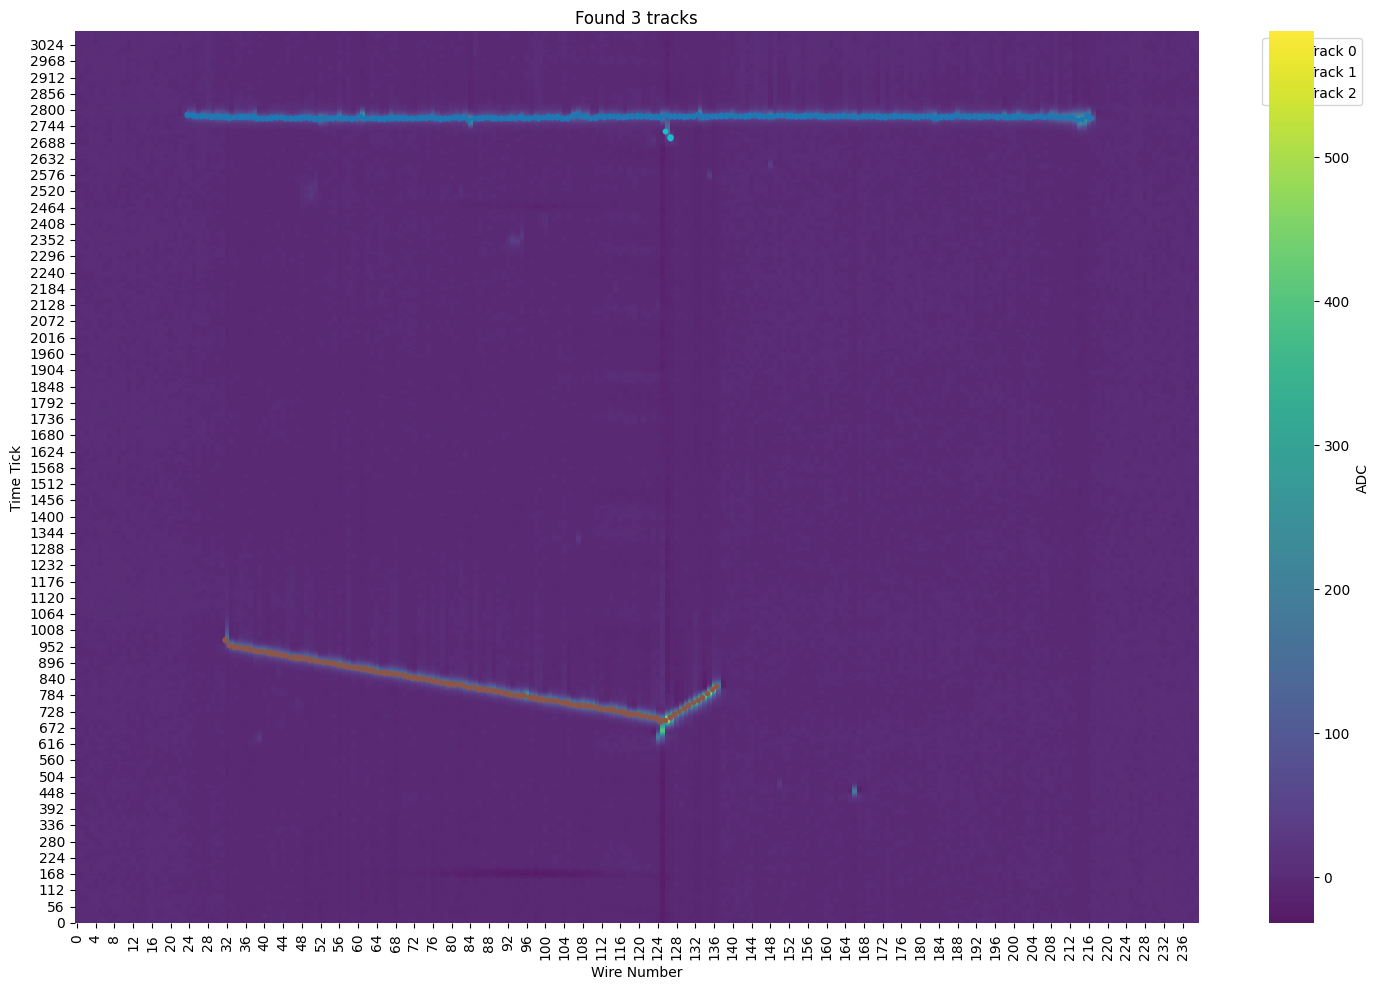

In [178]:
# Plot the tracks found
plt.figure(figsize=(15, 10))

# Plot the original  plane as background
sns.heatmap(plane.T, cmap='viridis', alpha=0.9, cbar_kws={'label': 'ADC'})

# Plot each track with a different color
colors = plt.cm.tab10(np.linspace(0, 1, len(tracks)))

for i, track in enumerate(tracks):
    ys, xs = track[:, 0], track[:, 1]
    plt.scatter(ys, xs, c=[colors[i]], s=10, alpha=1, label=f'Track {i}')

plt.xlabel("Wire Number")
plt.ylabel("Time Tick")
plt.title(f"Found {len(tracks)} tracks")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Undirected Graph

In [ ]:
from scipy.spatial import cKDTree

tree = cKDTree(points)

k = 5

rows = np.repeat(np.arange(len(points)), k)
cols   = tree.query(points, k+1)[1][:, 1:].ravel() # 2 nearest neighbours
pairs  = np.column_stack((rows, cols))

In [ ]:
# undirected graph

G = nx.Graph()
for idx, (y, x) in enumerate(points):
    G.add_node((y, x), value=adc[idx])

for i, j in pairs:
    p1 = tuple(points[i])
    p2 = tuple(points[j])

    dy, dx = p2[0] - p1[0], p2[1] - p1[1]

    angle = np.arctan2(dy, dx); degrees = np.degrees(angle)
    dist = np.hypot(dy, dx)
    
    adc_diff = abs(adc[i] - adc[j])

    G.add_edge(p1, p2, weight=dist, adc=adc_diff, distance=dist, angle=angle)

G.remove_nodes_from([n for n, d in G.degree if d == 0])


In [ ]:
T = nx.minimum_spanning_tree(G)

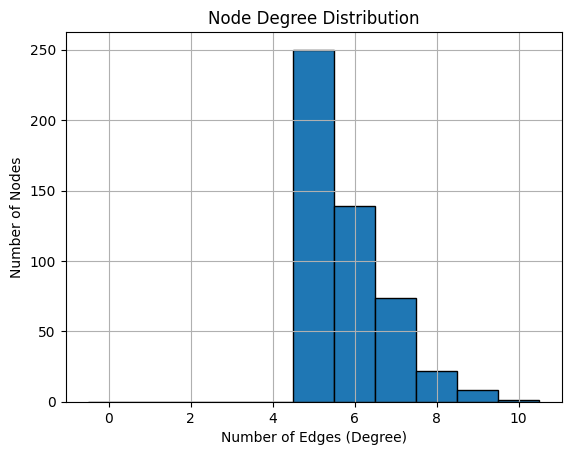

In [ ]:
import numpy as np

degree_values = np.array([deg for _, deg in G.degree()])

import matplotlib.pyplot as plt

plt.hist(degree_values, bins=np.arange(degree_values.max() + 2) - 0.5, edgecolor='black')
plt.title("Node Degree Distribution")
plt.xlabel("Number of Edges (Degree)")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()



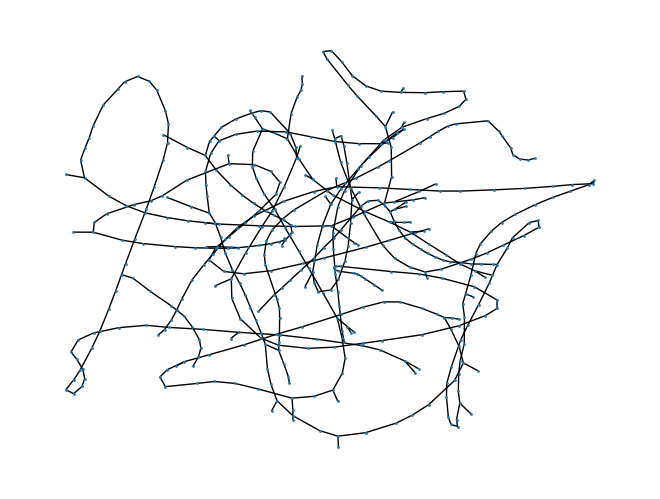

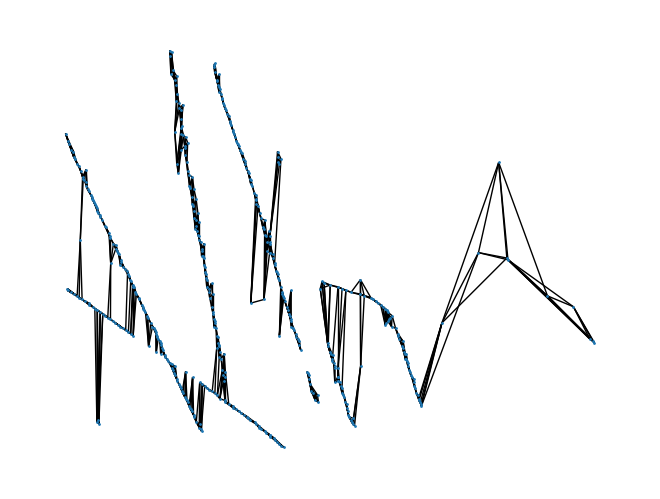

In [ ]:
pos = nx.spring_layout(T)

nx.draw(T, 
        pos,
        node_size=1,
        with_labels=False, 
        width=1)
plt.show()

pos = {node: (node[1], node[0]) for node in G.nodes}

nx.draw(G, 
        pos,
        node_size=1,
        with_labels=False, 
        width=1)

plt.show()

Different ways of finding maxima, to find points on the tracks for making graph nodes. 

Filter to find maxima

In [ ]:
from scipy.ndimage import maximum_filter
import numpy as np

# 1. a max filter in 2D
neighbourhood = (1, 50) # window size in these coordinates (wire, ticks)

local_max = (plane == maximum_filter(plane, size=neighbourhood))

# 2. Suppressing low values 
threshold = np.percentile(plane, 99) * 0.50 # TODO: needs to be adaptive, different for collection and induction
peak_mask = (plane > threshold) & local_max


Another filter

In [ ]:
window_size = 500
rows, cols = plane.shape
block_max = np.zeros_like(plane, dtype=bool)

for r in range(rows):
    for c in range(0, cols, window_size):
        block = plane[r, c:c+window_size]
        if len(block) == 0:
            continue
        max_val = np.max(block)
        max_pos = np.where(block == max_val)[0]
        # Mark all max positions as True in mask
        block_max[r, c + max_pos] = True

threshold = np.percentile(plane, 99) * 0.50 # TODO: needs to be adaptive, different for collection and induction
peak_mask = (plane > threshold) & block_max

In [ ]:
# import math, heapq, itertools, numpy as np

# def angle_diff(a1, a2):
#     return min(abs(a1-a2) , 360 - abs(a1-a2))

# def lookahead(G, root, max_depth=2):
#     seen = {root}
#     heap = [(0.0, 0, root, None)]

#     while heap:
#         cost, depth, node, first = heapq.heappop(heap)
#         if depth == max_depth:
#             return first, cost
        
#         for nxt in G.successors(node):
#             if nxt in seen:
#                 continue
#             seen.add(nxt)
#             edge_dist = G[node][nxt]['distance']
#             heapq.heappush(heap,
#                         (cost + edge_dist,
#                             depth + 1, 
#                             nxt,
#                             first or nxt))
        
#     return None, None

# def buildtrack(G, start_node, startdepth=2, angle_thresh=45, first_step_max=20, nsigma = 6, adc_thresh=None):
#     track = [start_node]
#     current = start_node
#     prev_angle = None           
#     prev_adc     = G.nodes[start_node]['adc']
#     angles = []
#     adcs = []
#     dists = []
    
#     while True:

#         if current is start_node:
#             nxt, best_dist = lookahead(G, current, startdepth)
#             if nxt is None:
#                 break

#             first_edge_dist = G[current][nxt]['distance']
#             if first_step_max is not None and first_edge_dist > first_step_max:
#                 break

#             best = nxt
#             best_dist = first_edge_dist
#             best_angle = G[current][nxt]['angle']
#             best_adc = G.nodes[nxt]['adc']

#         else:
            
#             candidates = list(G.successors(current))
#             if not candidates:
#                 break

#             best = None
#             best_score = float('inf')

#             if len(dists) >= 1:
#                 mu = np.mean(dists)
#                 sig = np.std(dists, ddof=1)

#             else:
#                 mu = sig = None
            
            
#             for nxt in candidates:
#                 edge = G[current][nxt]
#                 dist = edge['distance']
#                 angle = edge['angle']

#                 if dist > 70:
#                     continue

#                 if current is start_node and first_step_max is not None:
#                     if dist > first_step_max:
#                         continue

#                 if mu is not None and sig > 0:
#                     if dist > mu + nsigma * sig:
#                         continue

#                 adc_nxt = G.nodes[nxt]['adc']
#                 if adc_thresh is not None:
#                     if abs(adc_nxt - prev_adc) > adc_thresh:
#                         continue

#                 if prev_angle is not None:
#                     delta = angle_diff(prev_angle, angle)
#                     if delta > angle_thresh:
#                         continue
#                 else:
#                     delta = 0

#                 if delta < best_score:
#                     best = nxt
#                     best_score = delta
#                     best_dist = dist
#                     best_adc = adc_nxt

#             if best is None:
#                 break

#         track.append(best)
#         dists.append(best_dist)
#         prev_angle = G[current][best]['angle']; angles.append(prev_angle)
#         prev_adc = best_adc
#         current = best

#     return track, angles

/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_4092/341534561.py:3: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  plt.rcParams['toolbar'] = 'toolmanager'
/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_4092/341534561.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 6))


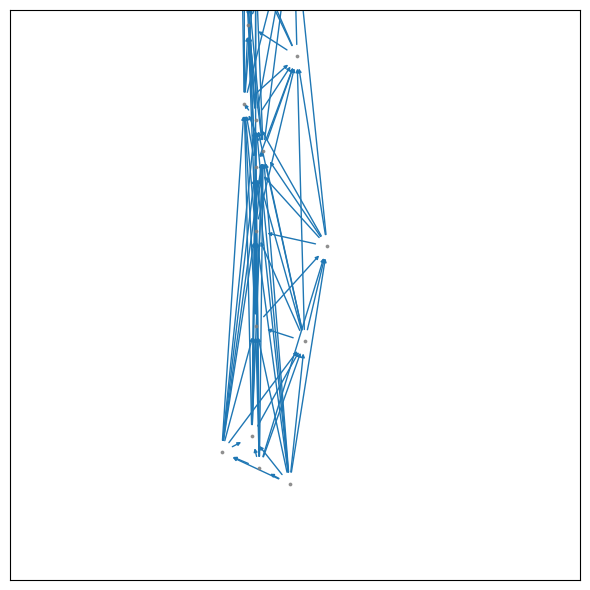

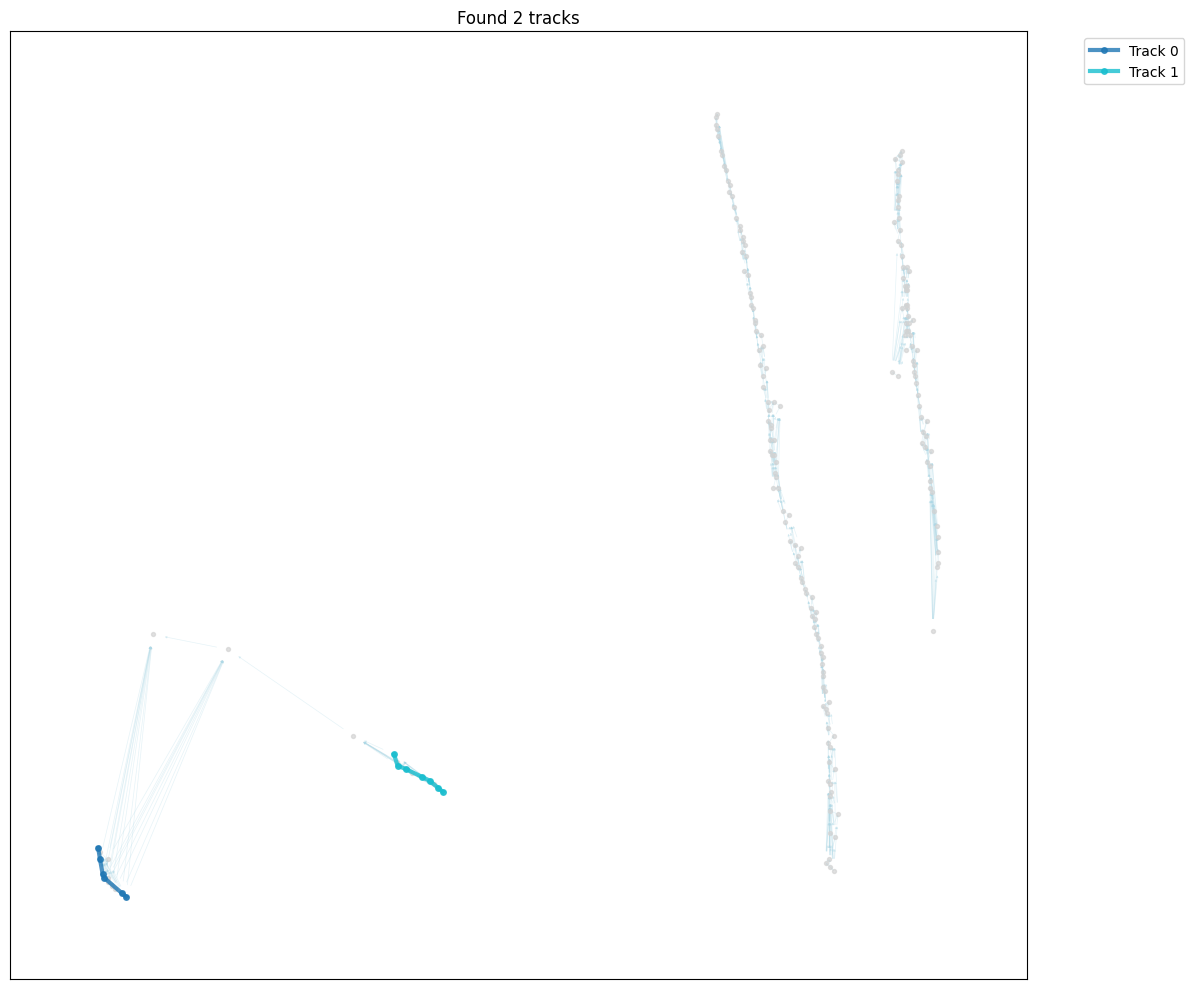

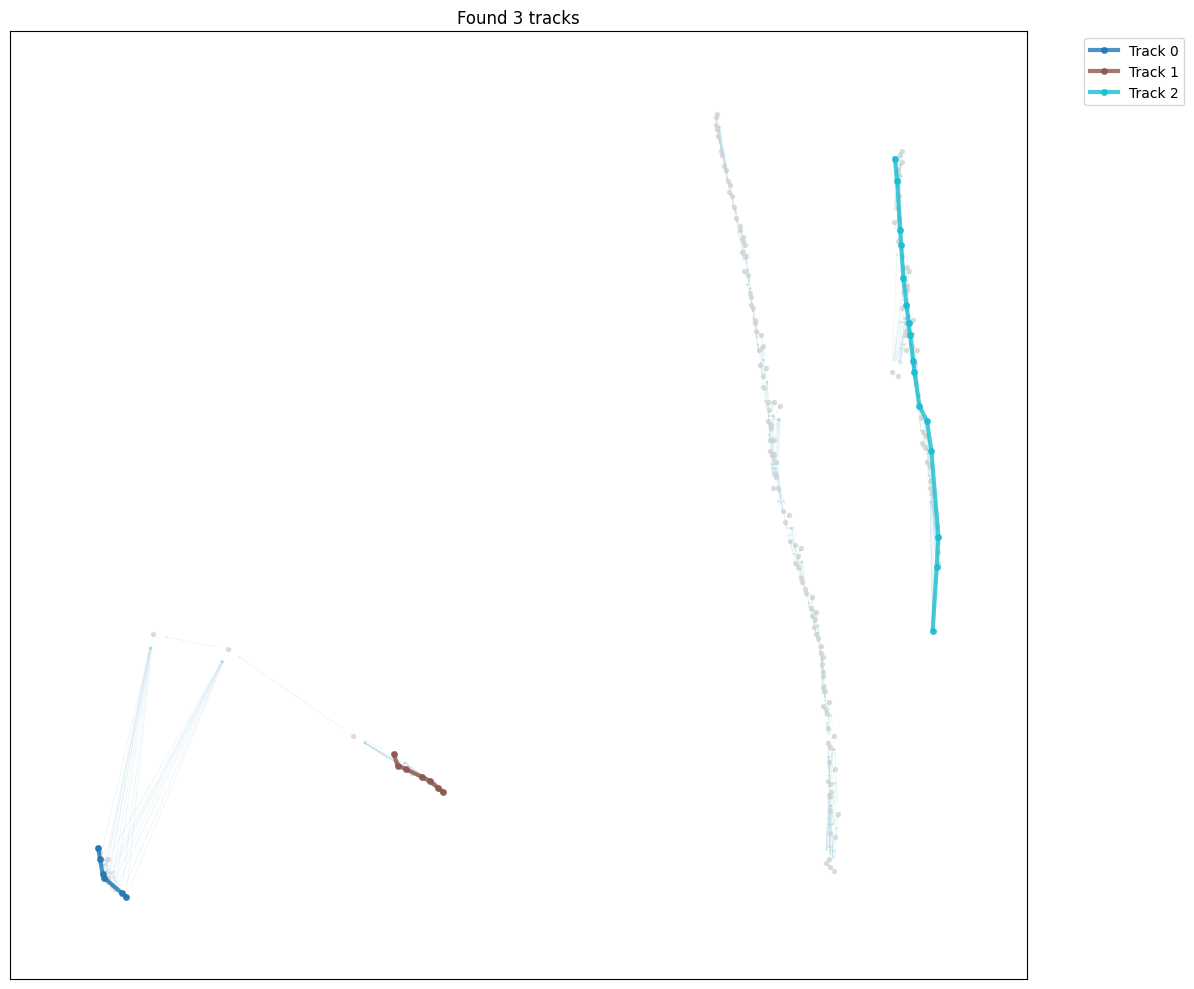

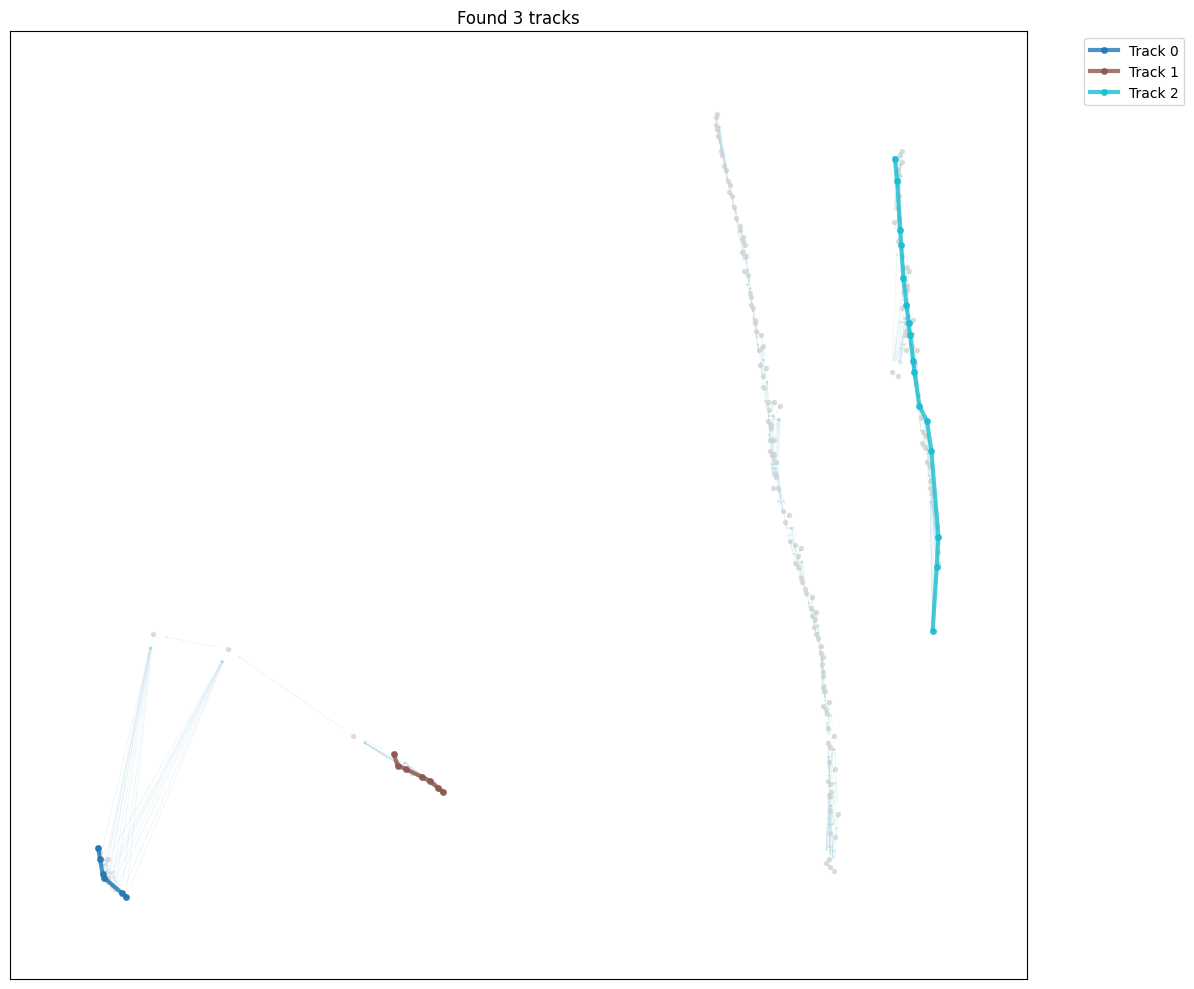

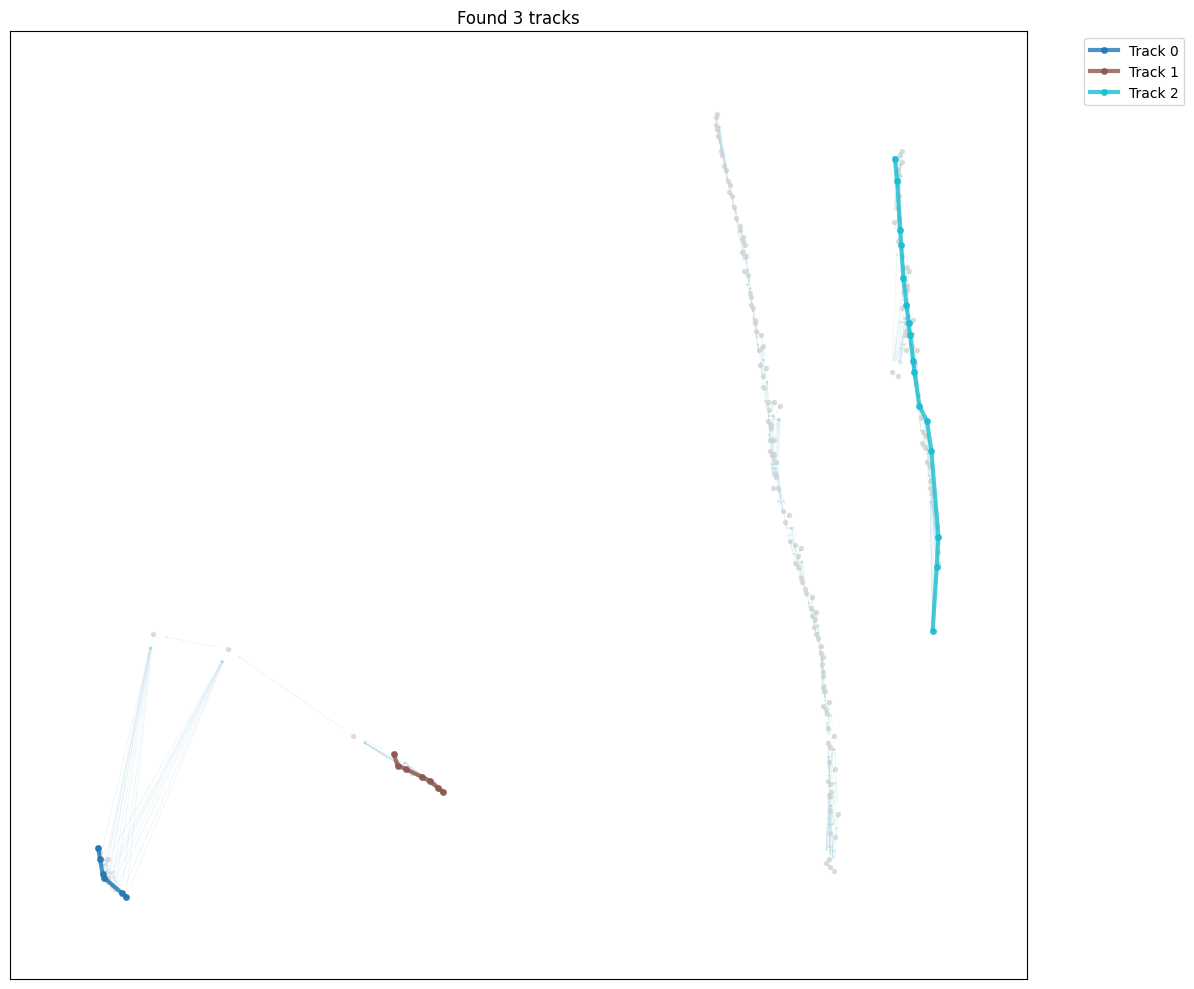

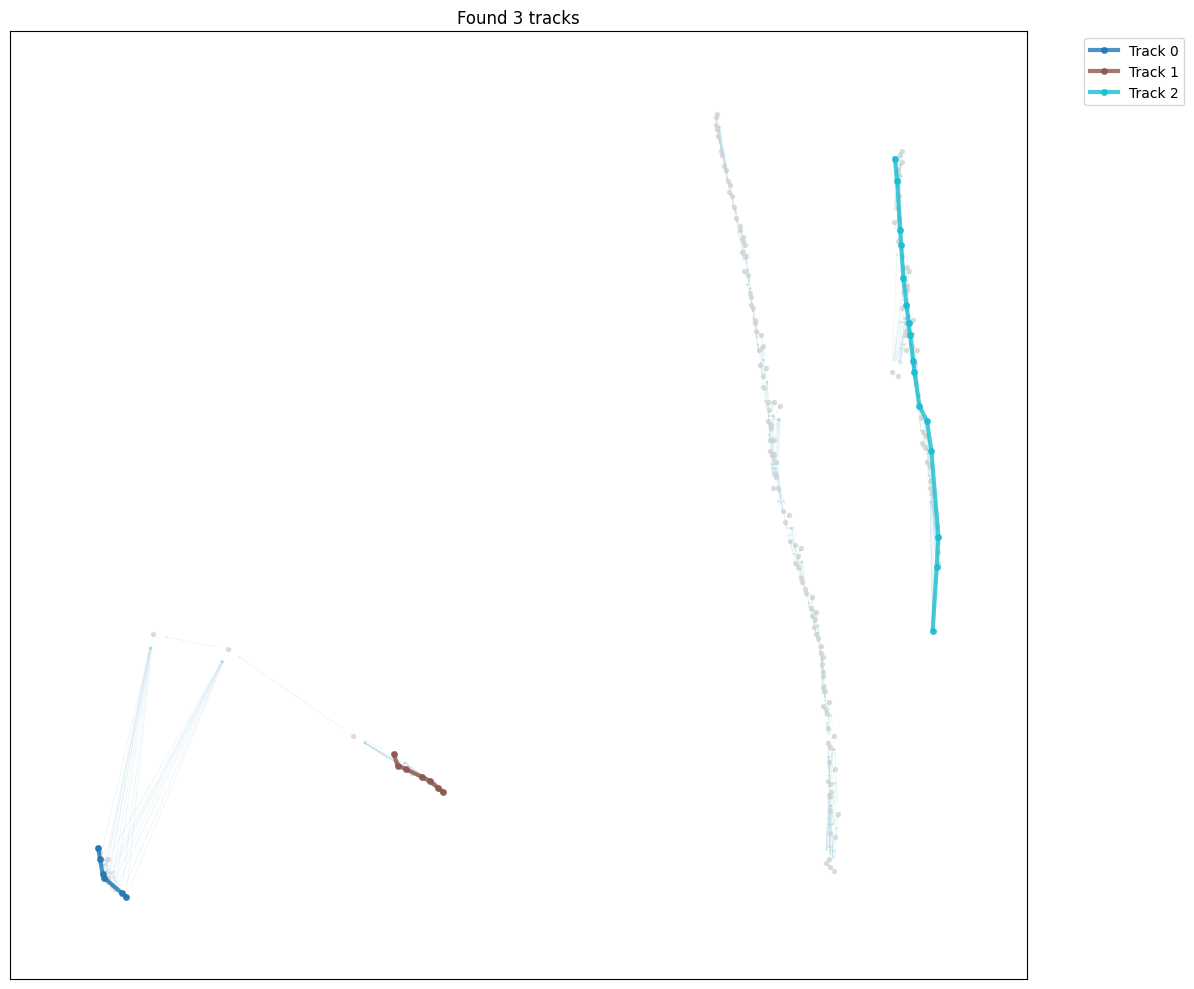

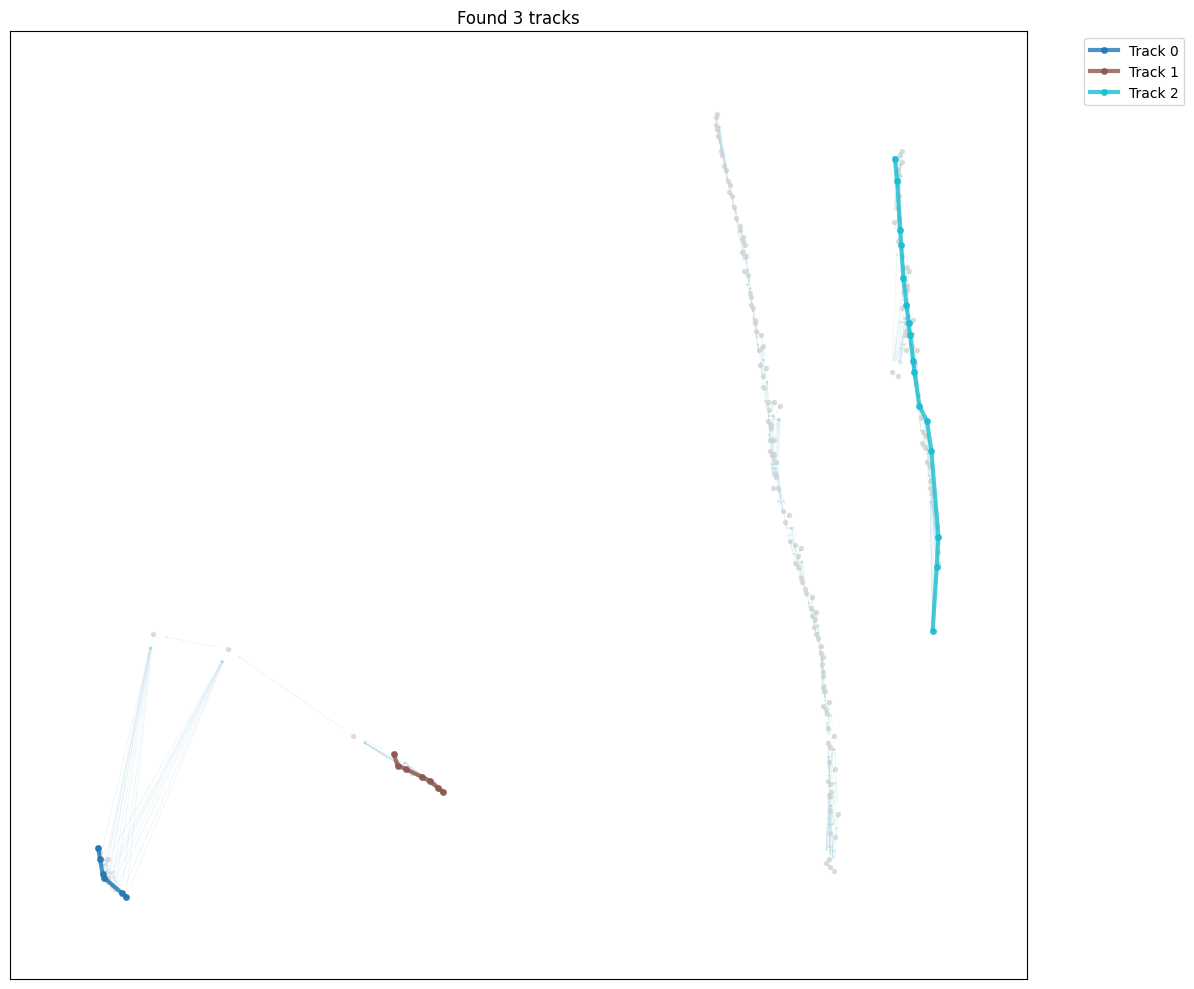

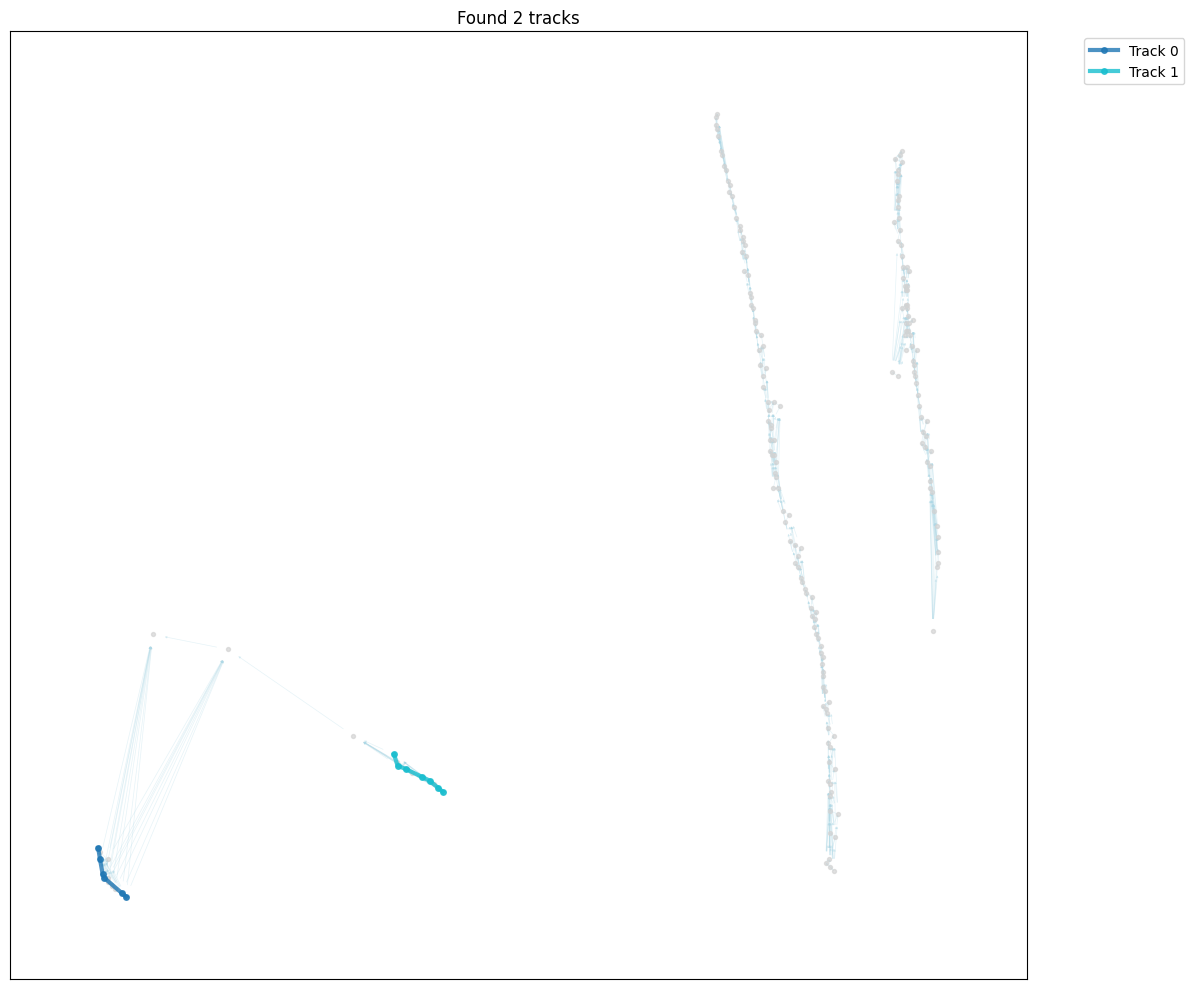

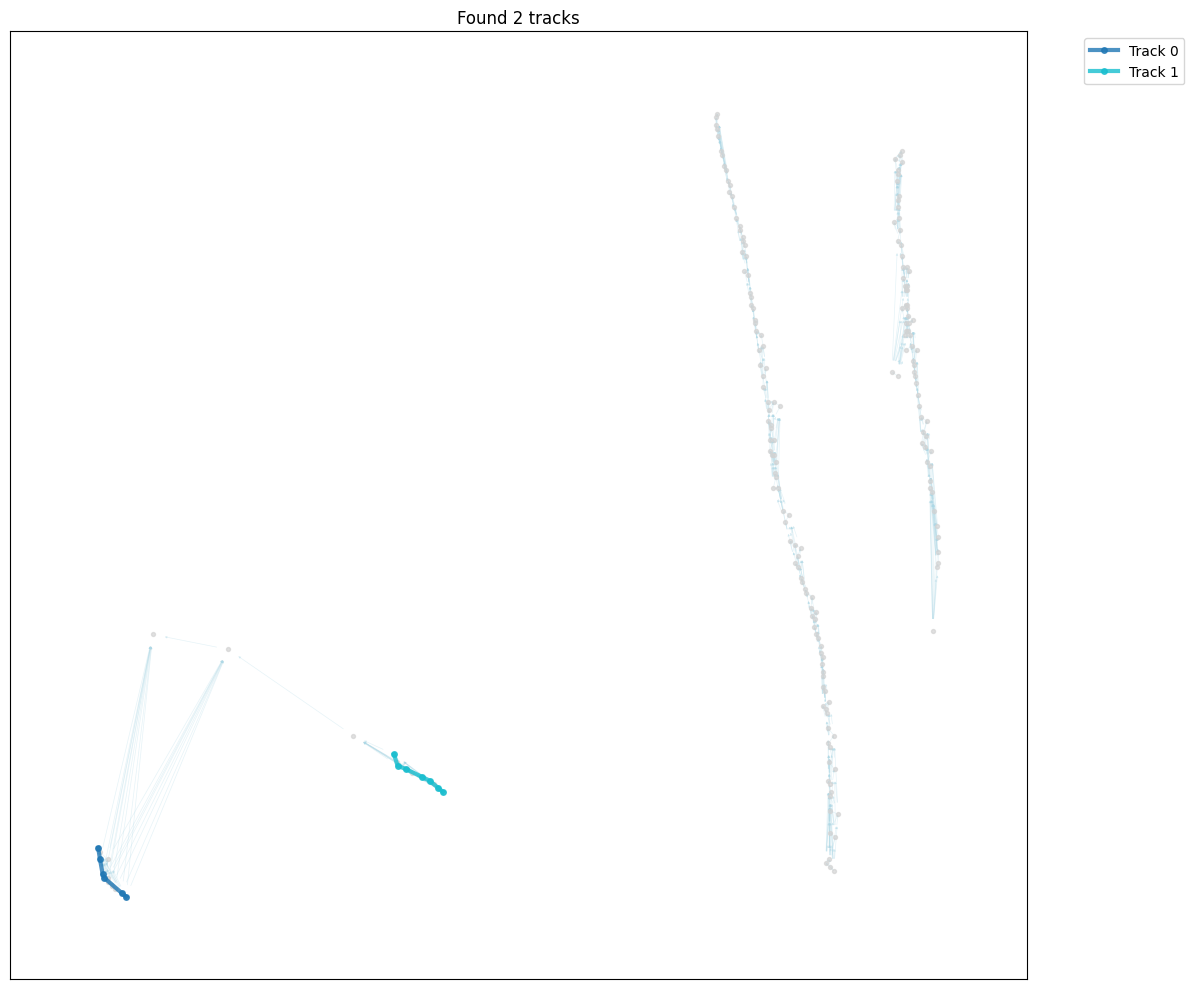

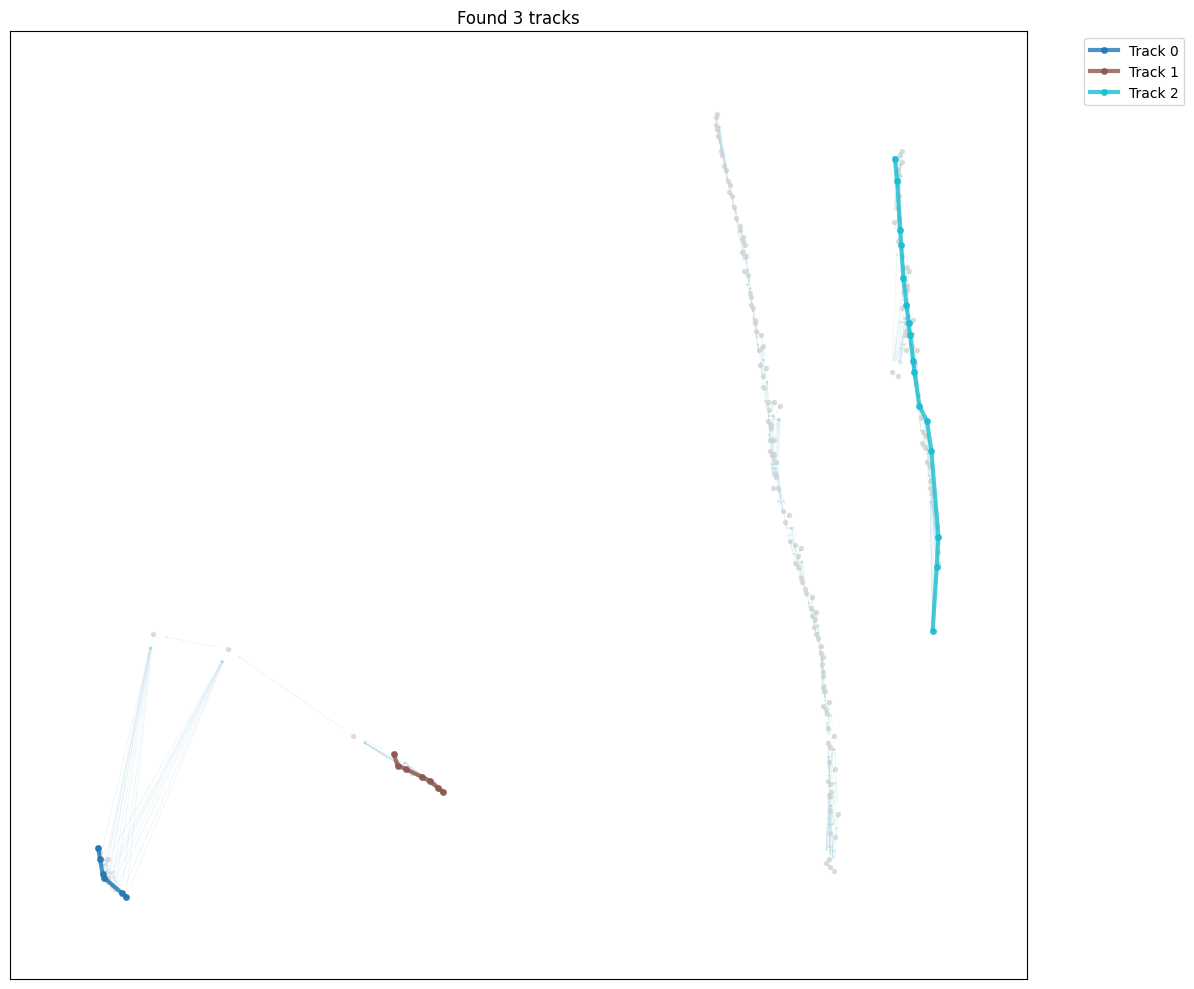

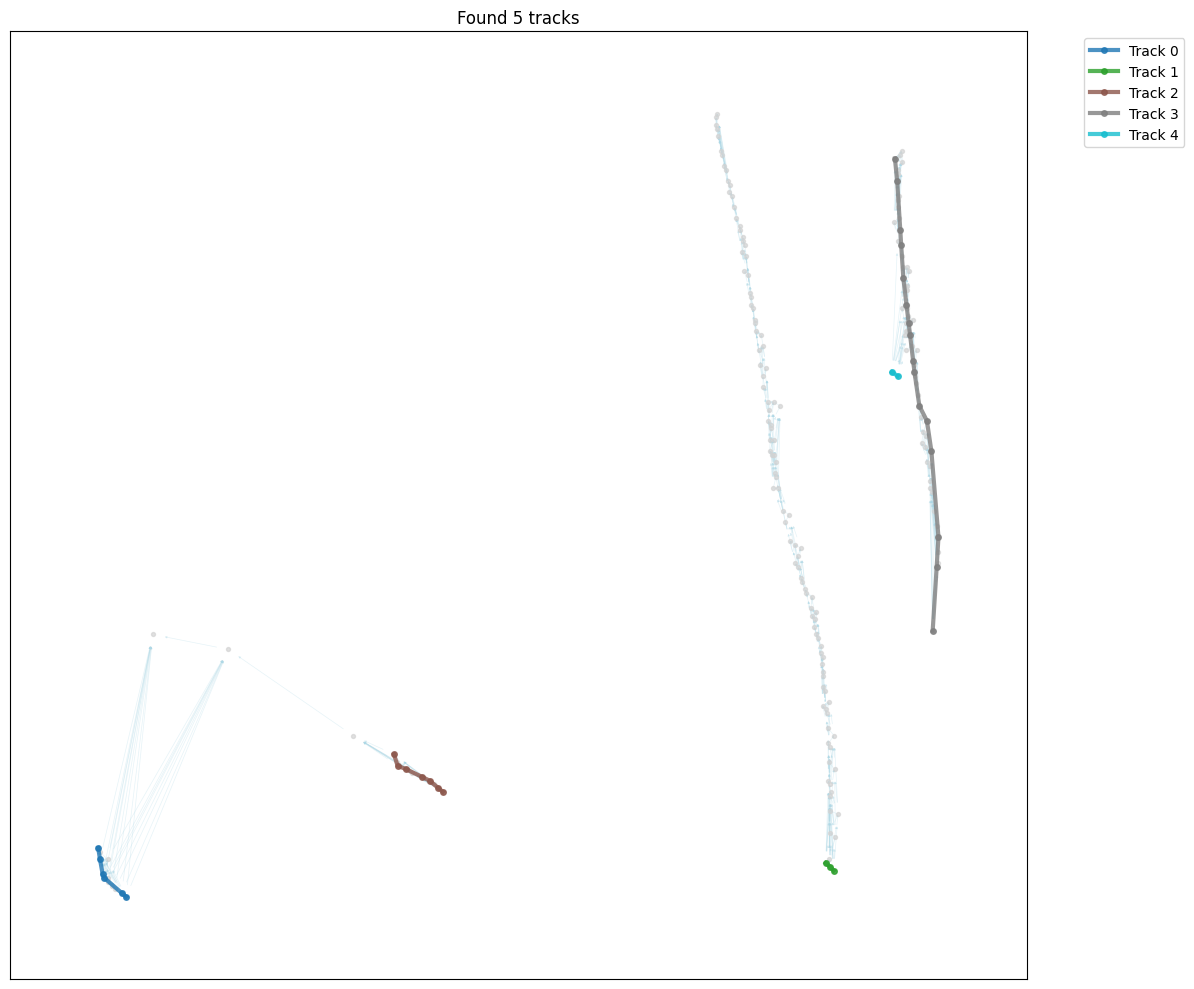

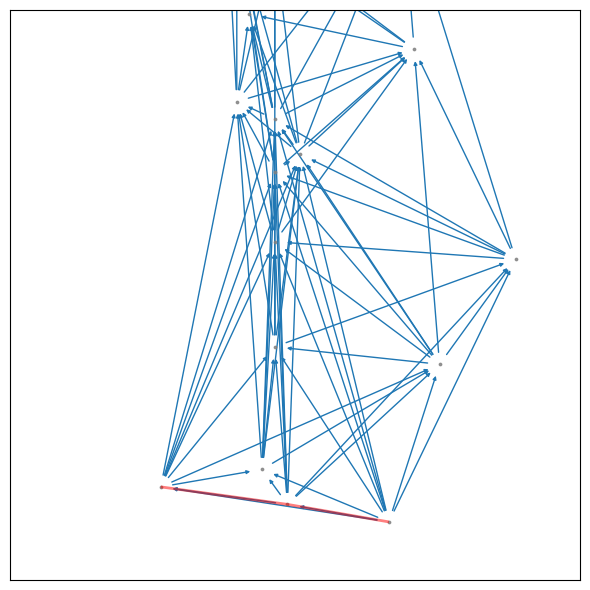

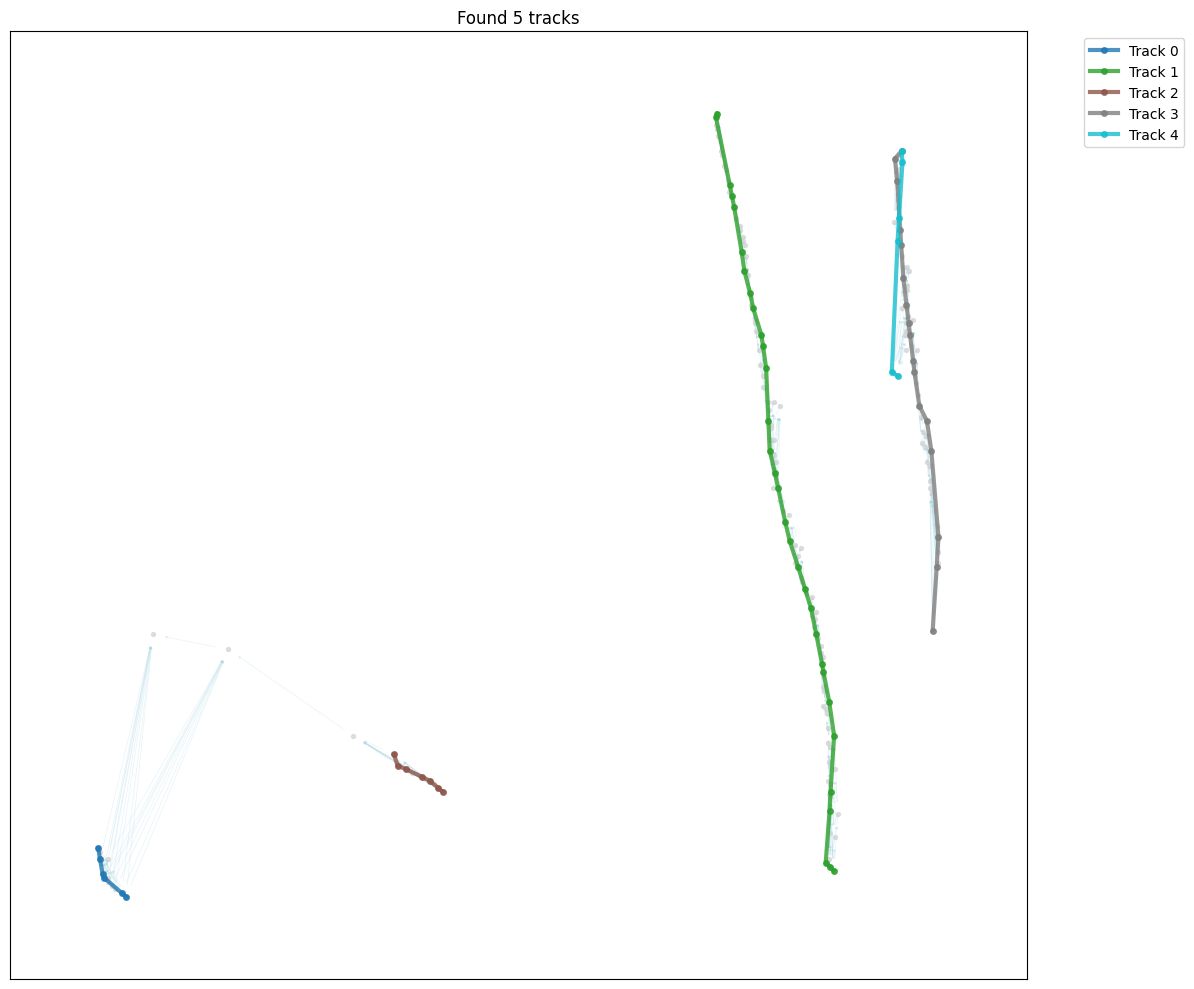

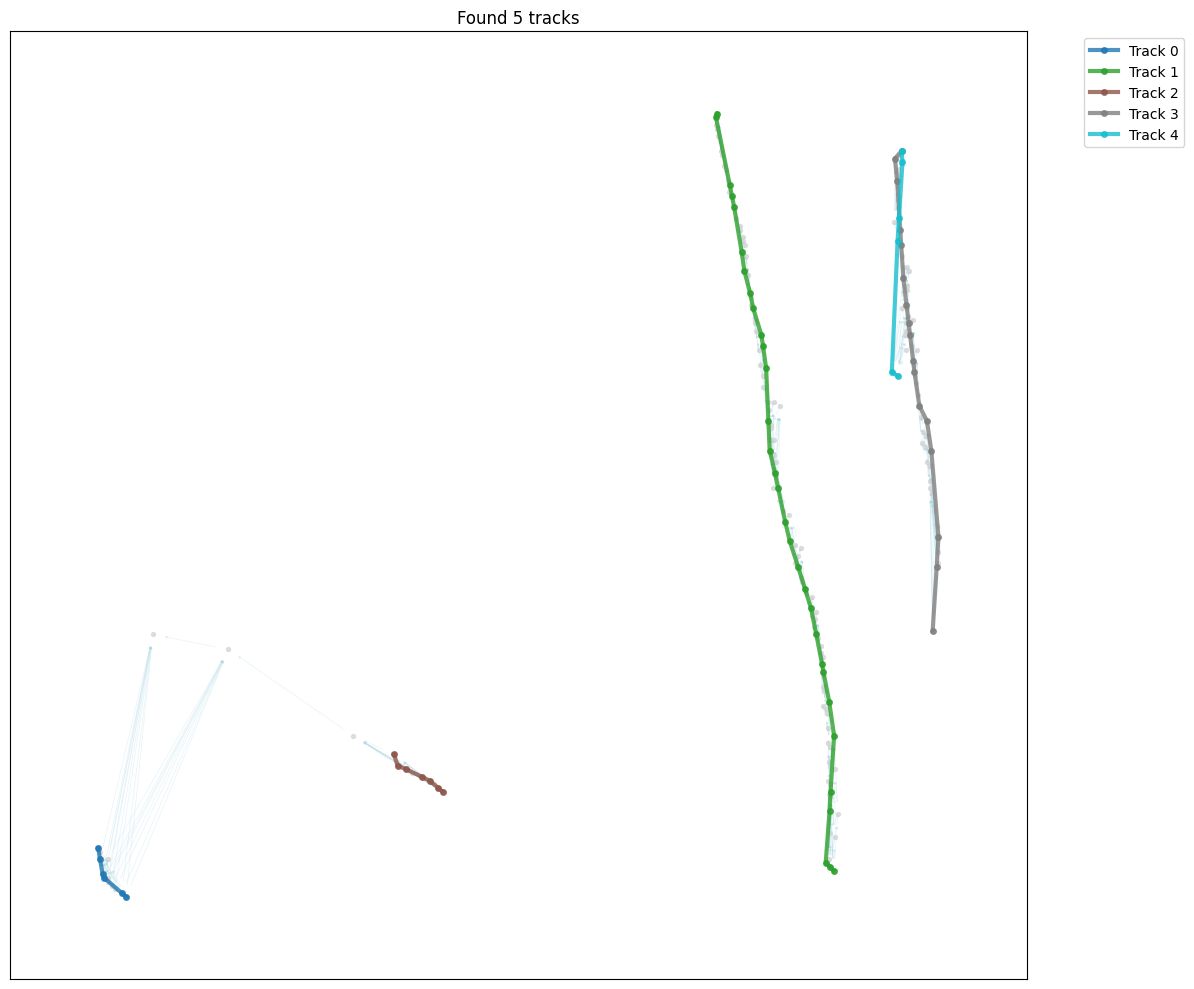

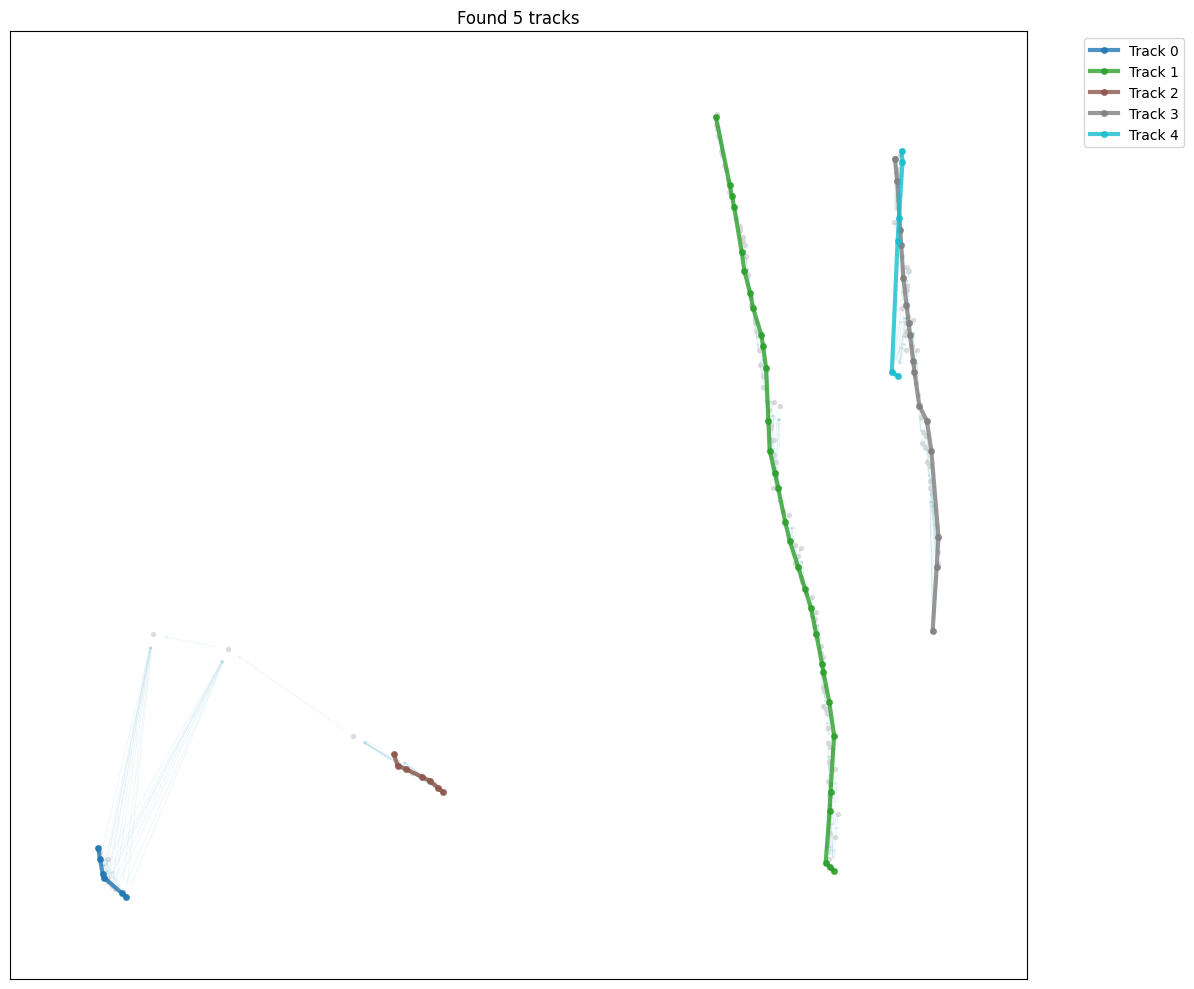

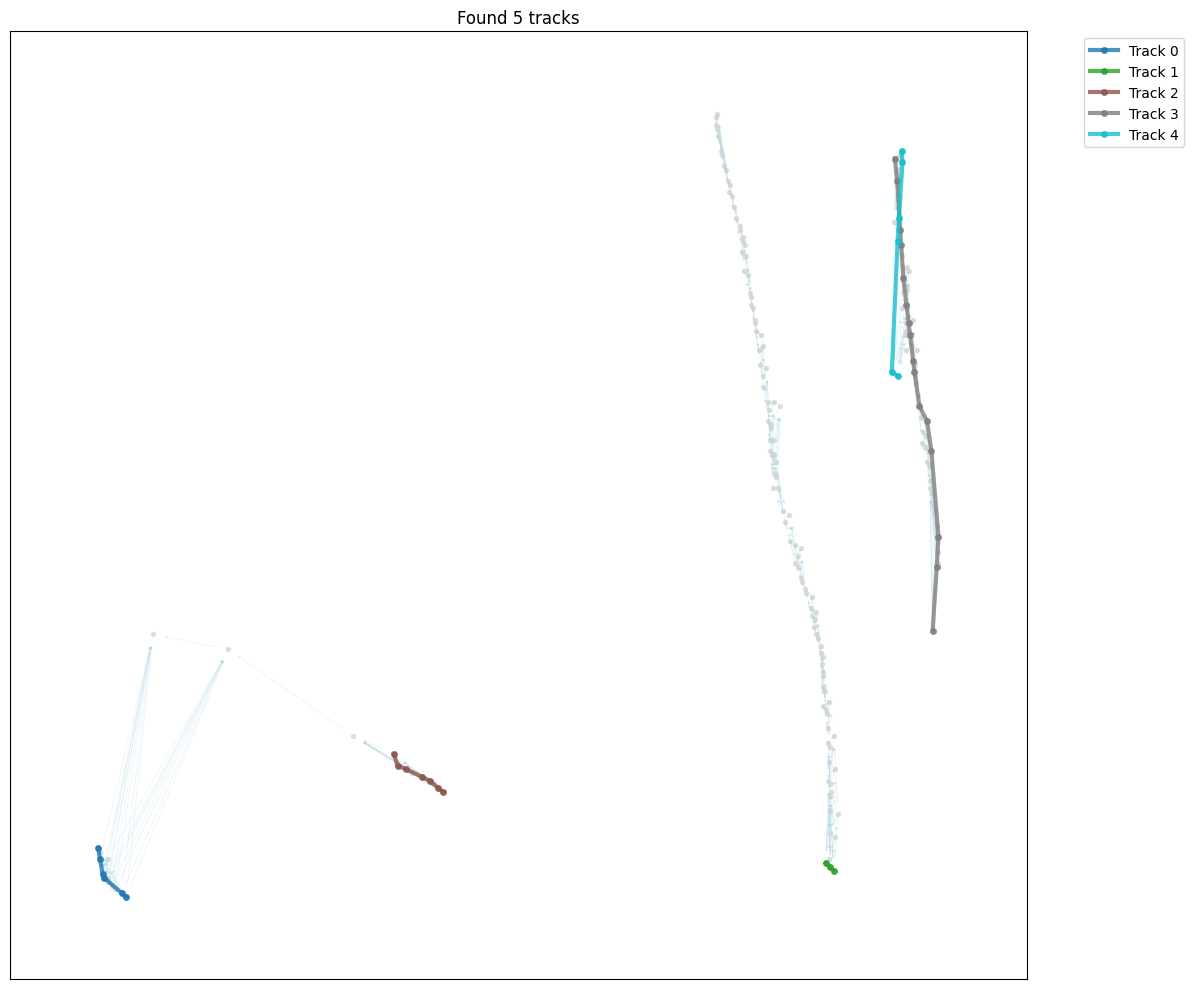

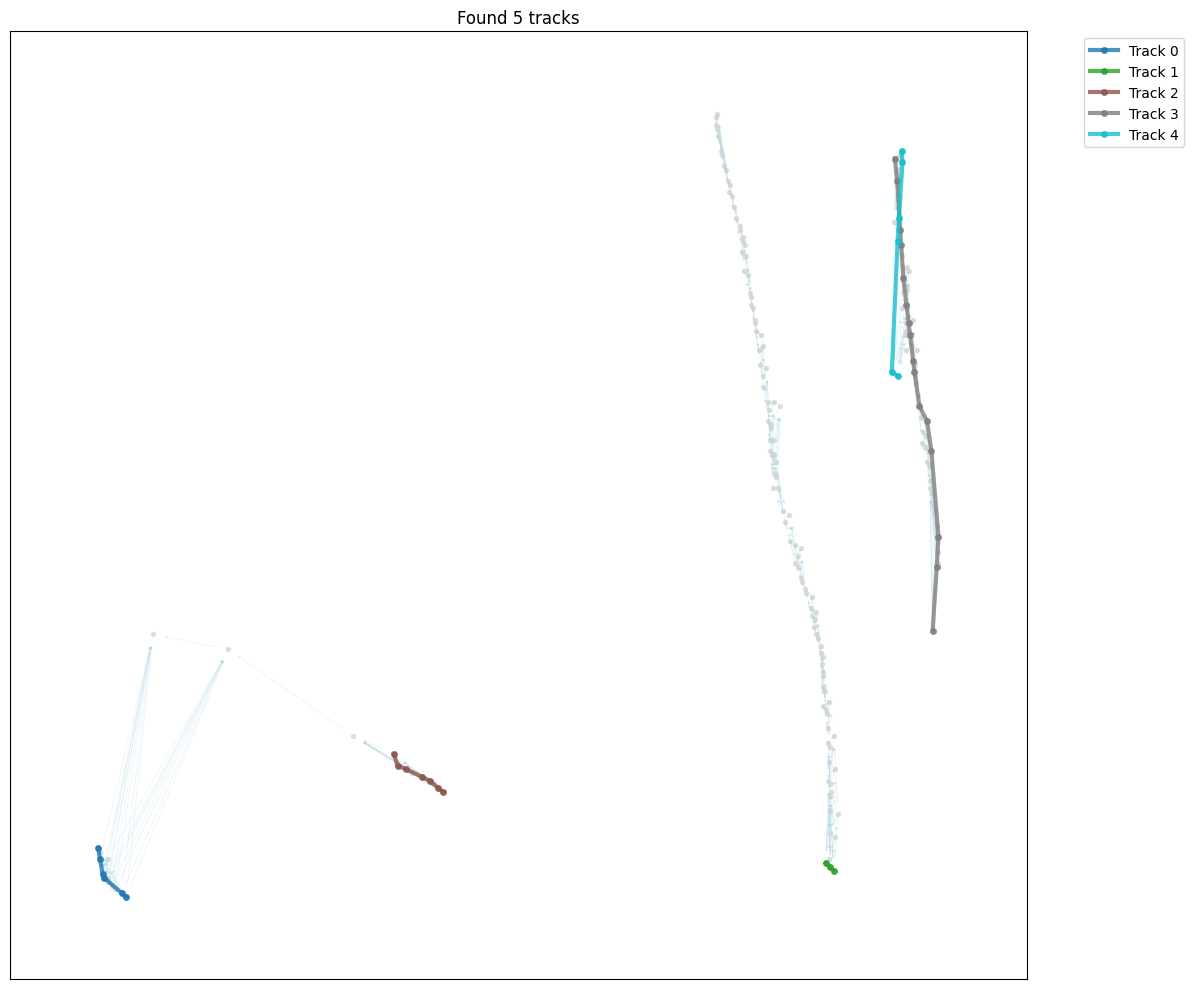

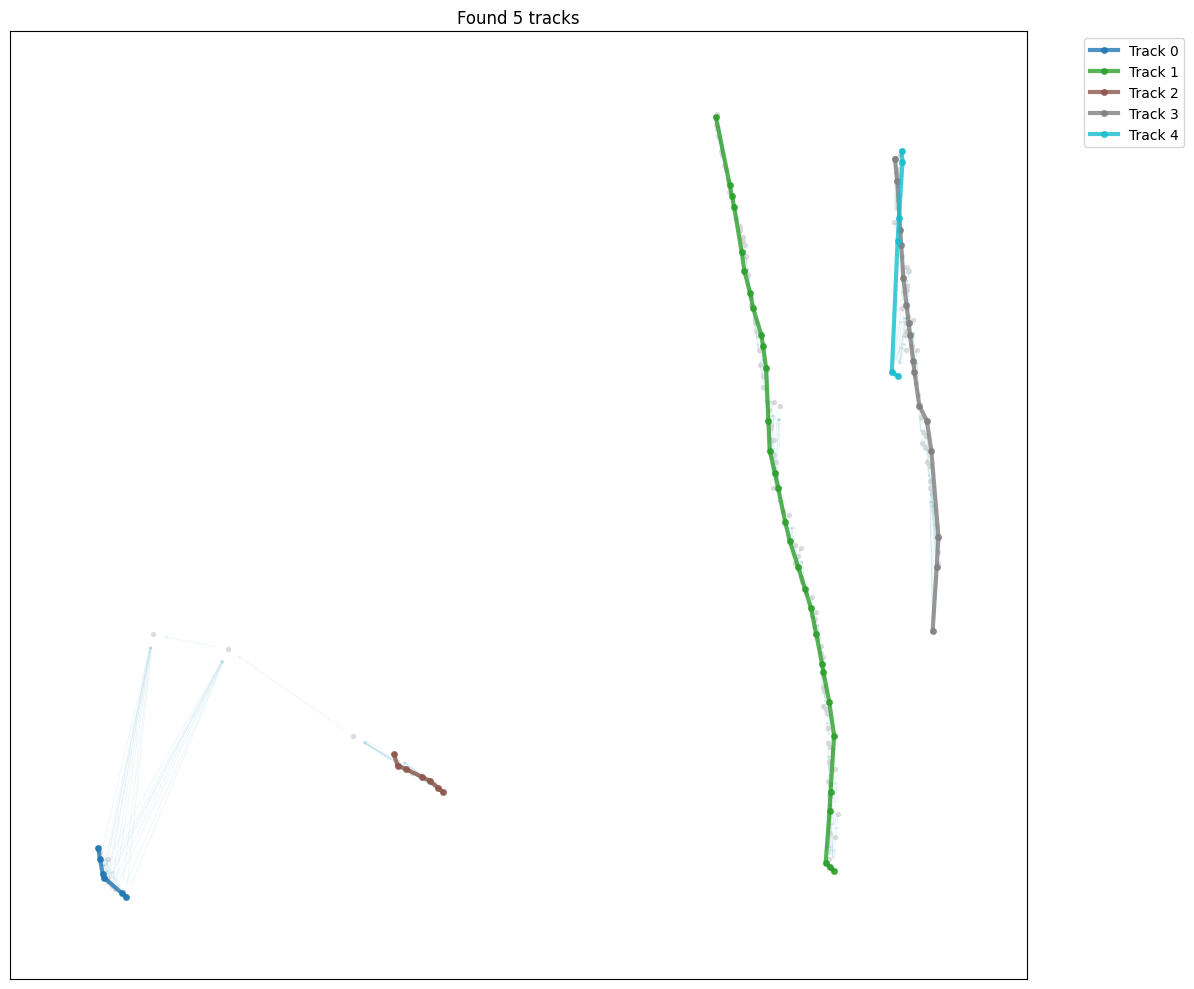

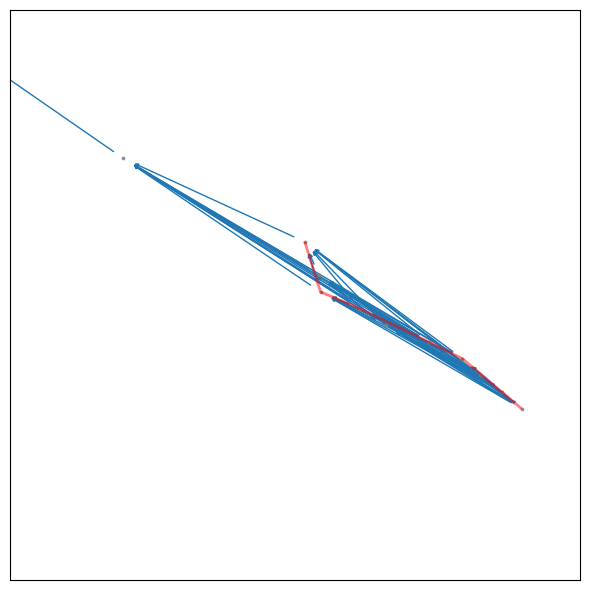

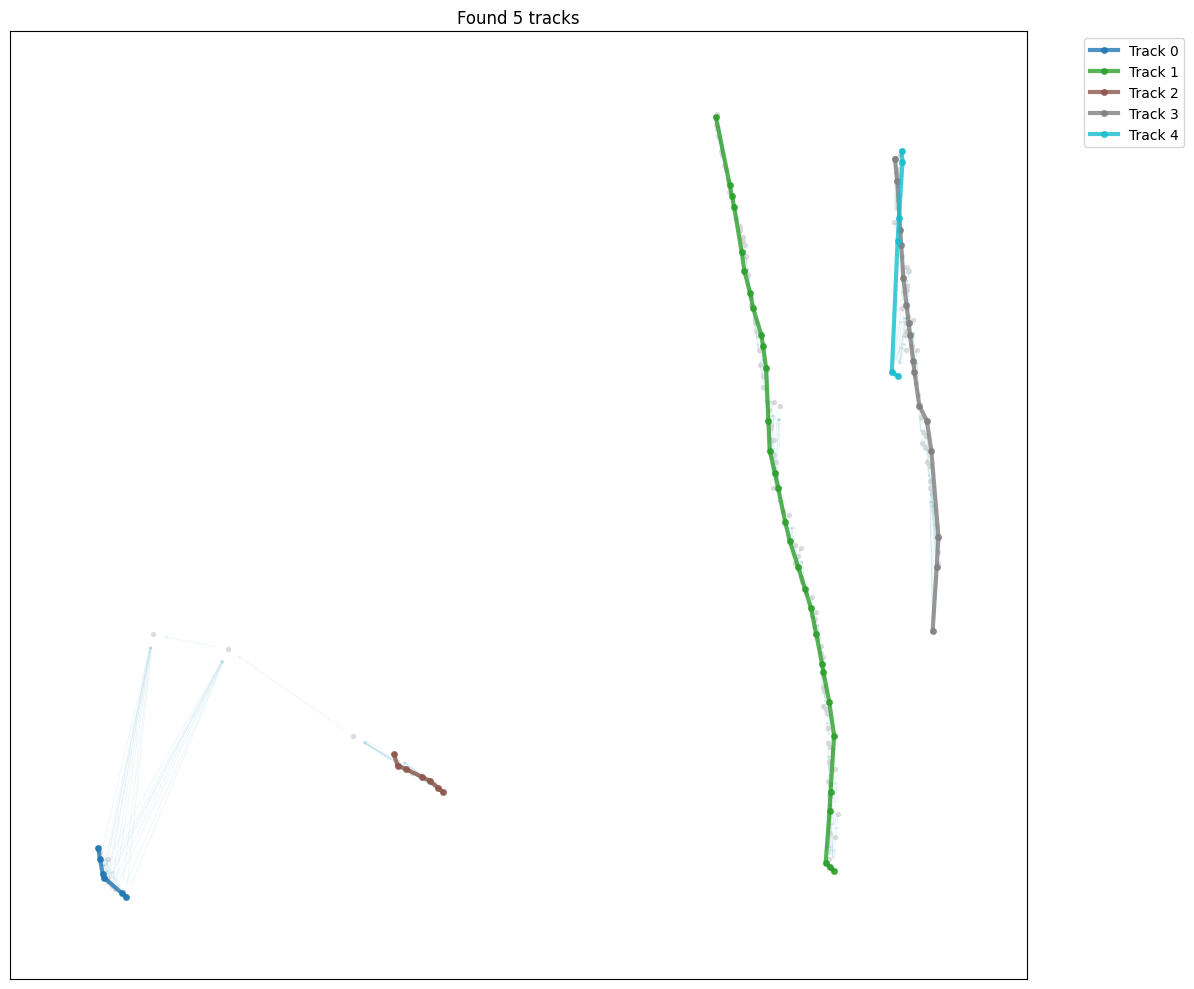

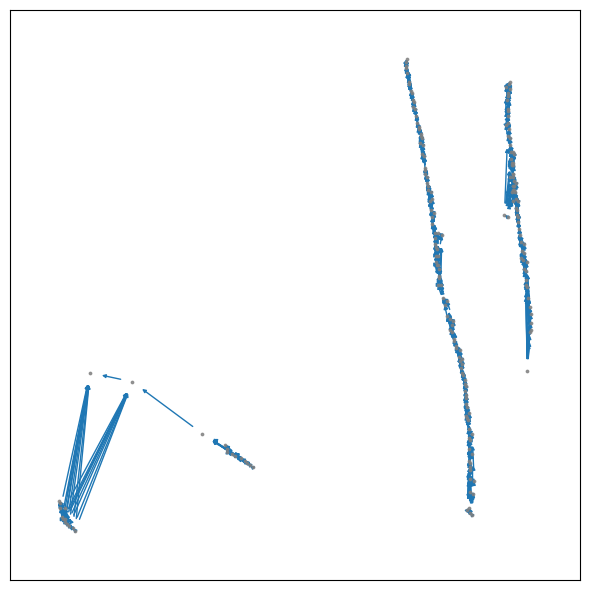

In [816]:
%matplotlib inline

plt.rcParams['toolbar'] = 'toolmanager'

pos = nx.get_node_attributes(G, 'pos')

fig, ax = plt.subplots(figsize=(6, 6))

# Draw edges
nx.draw_networkx_edges(
        G, pos,
        ax          = ax,
        arrows      = True,
        arrowsize   = 5,
        arrowstyle  = '-|>',
        width       = 1,
        edge_color  = 'tab:blue')

# Draw nodes
nx.draw_networkx_nodes(
        G, pos,
        ax          = ax,
        node_size   = 3,
        node_color  = 'grey',
        alpha       = 0.8)

ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
plt.show()

from matplotlib.collections import LineCollection
import matplotlib.cm as cm          # only if you want auto-colours later

# 1. Convert every track (list of node ids) → array of xy points
def track_as_xy(track, pos_dict):
    """Return (N,2) array for a single track."""
    return np.array([pos_dict[n] for n in track])

segments = [track_as_xy(t, pos) for t in tracks if len(t) > 1]

# 2. Make a single LineCollection
track_lc = LineCollection(
            segments,
            colors='red',        # ← all red; or give a list the same length as `segments`
            alpha=0.5,
            linewidths=2.0,
            zorder=4)            # ensure it sits on top of the blue edges

# 3. Add to the existing axes and redraw
ax.add_collection(track_lc)
fig.canvas.draw_idle()            # for %matplotlib widget
